### IMPORTS

In [1]:
%%time
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from scipy import stats

import abt
# This module contains 3 self-made functions:
# read_abt(x)
# p_factor(*factor, goal, df, variations=[1,2], min=50)
# tta(*factor, goal, df, variations=[1,2], min=50)


# Import VIZ Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import altair as alt
import pygal

# Jupyter Settings
pd.options.display.max_columns = None
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 200)

%config InlineBackend.figure_format = 'retina' # display plots in retina

# Output Multiple Values for Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Output logs and warnings
import logging
logging.basicConfig(level=logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

# Global Variables
AP, DC, FC, MB, SC = 539414, 527076, 539416, 539420, 529239

import boto3
s3 = boto3.resource('s3')
bucket=s3.Bucket('vwo-ab-tests-bucket')
filelist = [] 
for file in bucket.objects.all():
    filelist.append(file.key) 
s_filelist = pd.Series(filelist)

import pyperclip

print("Setup Complete")

Setup Complete
CPU times: user 3.46 s, sys: 810 ms, total: 4.27 s
Wall time: 6.44 s


## CLEAR DATA

### LOAD EXP FROM AMAZON S3

In [2]:
exp = 135

In [3]:
current = SC

In [4]:
%%time
# LOAD META REPORT
s3 = boto3.client('s3')
meta_list = list(s_filelist[s_filelist.str.contains('meta')\
                            & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)])
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=meta_list[0])
meta = pd.read_csv(obj['Body'], compression='gzip')

print('SHAPE of META file =', meta.shape)
print('WORKING FILE = ', meta_list[0])

SHAPE of META file = (40, 6)
WORKING FILE =  529239/135/meta.csv.gz
CPU times: user 27.4 ms, sys: 4.27 ms, total: 31.7 ms
Wall time: 401 ms


In [5]:
%%time
# LOAD AND CLEAN LAST DETAILED REPORT
s3 = boto3.client('s3')
detailed = list(s_filelist[s_filelist.str.contains('^(?!.*meta).*$', regex=True)\
                           & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)]\
                           .sort_values(ascending=False))
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=detailed[0])
original = abt.read_abt(obj['Body'], meta=meta)

print('ORIGINAL SHAPE as is in S3 =',original.shape)
print('WORKING FILE = ', detailed[0])

ORIGINAL SHAPE as is in S3 = (78237, 144)
WORKING FILE =  529239/135/20220304.csv.gz
CPU times: user 15.6 s, sys: 1.06 s, total: 16.6 s
Wall time: 20.7 s


In [6]:
%%time
# LOAD RAW REPORT
s3 = boto3.client('s3')
detailed = list(s_filelist[s_filelist.str.contains('^(?!.*meta).*$', regex=True)\
                           & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)]\
                           .sort_values(ascending=False))
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=detailed[0])
raw = pd.read_csv(obj['Body'], compression='gzip')

print('RAW SHAPE as is in S3 =', raw.shape)

RAW SHAPE as is in S3 = (78237, 99)
CPU times: user 1.59 s, sys: 242 ms, total: 1.84 s
Wall time: 6.09 s


In [7]:
metrics = list(meta[:-4]['name'])
print(metrics)
pyperclip.copy(str(metrics))

['engagement', 'ctr_on_login', 'all_payment_systems_submit', 'learn_more_link_ctr', 'get_started_offers_ctr', 'tourneys_ctr', 'mystery_museum_demo_ctr', 'mystery_museum_play_ctr', 'rock_roll_demo_ctr', 'rock_roll_play_ctr', 'aloha_demo_ctr', 'aloha_play_ctr', 'adventure_log_ctr', 'playson_game_search_ctr', 'game_search_ctr', 'redtiger_game_search_ctr', 'ctr_on_signup', 'statusprogram_ctr', 'cashier_open_ctr', 'playngo_game_search_ctr', 'demo_game', 'play_game', 'quickspin_game_search_ctr', 'responsiblegaming_ctr', 'microgaming_game_search_ctr', 'yggdrasil_game_search_ctr', 'cabinet/promo', 'games/slots', 'signup_completed', 'login_completed', 'ftd', 'email_confirmed', 'retention_day_1', 'retention_day_3', 'retention_day_5', 'retention_day_7']


In [8]:
meta

category   id                         name               type  \
0          goal    1                   engagement         engagement   
1          goal    3                 ctr_on_login          clickLink   
2          goal    5   all_payment_systems_submit       clickElement   
3          goal    6          learn_more_link_ctr          visitPage   
4          goal    7       get_started_offers_ctr          visitPage   
5          goal    8                 tourneys_ctr          visitPage   
6          goal    9      mystery_museum_demo_ctr          visitPage   
7          goal   10      mystery_museum_play_ctr          visitPage   
8          goal   11           rock_roll_demo_ctr          visitPage   
9          goal   12           rock_roll_play_ctr          visitPage   
10         goal   13               aloha_demo_ctr          visitPage   
11         goal   14               aloha_play_ctr          visitPage   
12         goal   15            adventure_log_ctr          visitPage   
13         goal   16      playson_game_search_ctr          visitPage   
14         goal   17              game_search_ctr          visitPage   
15         goal   18     redtiger_game_search_ctr          visitPage   
16         goal   19                ctr_on_signup          visitPage   
17         goal   20            statusprogram_ctr          visitPage   
18         goal   21             cashier_open_ctr          visitPage   
19         goal   22      playngo_game_search_ctr          visitPage   
20         goal   23                    demo_game          visitPage   
21         goal   24                    play_game          visitPage   
22         goal   25    quickspin_game_search_ctr          visitPage   
23         goal   26        responsiblegaming_ctr          visitPage   
24         goal   27  microgaming_game_search_ctr          visitPage   
25         goal   28    yggdrasil_game_search_ctr          visitPage   
26         goal   29                cabinet/promo          visitPage   
27         goal   30                  games/slots          visitPage   
28         goal  201             signup_completed  custom-conversion   
29         goal  202              login_completed  custom-conversion   
30         goal  203                          ftd  custom-conversion   
31         goal  205              email_confirmed  custom-conversion   
32         goal  206              retention_day_1  custom-conversion   
33         goal  207              retention_day_3  custom-conversion   
34         goal  208              retention_day_5  custom-conversion   
35         goal  209              retention_day_7  custom-conversion   
36         goal  212             bonus_activation  custom-conversion   
37  combination    1                      Control                NaN   
38  combination    2                  Variation 1                NaN   
39     campaign  135                      Stories                NaN   

      created_timestamp  info  
0   2021-11-18 10:26:51   NaN  
1   2021-11-18 10:26:51   NaN  
2   2021-11-18 10:26:51   NaN  
3   2022-02-03 19:51:59   NaN  
4   2022-02-03 19:53:19   NaN  
5   2022-02-03 19:54:25   NaN  
6   2022-02-03 19:56:33   NaN  
7   2022-02-03 19:56:33   NaN  
8   2022-02-03 19:57:39   NaN  
9   2022-02-03 19:58:27   NaN  
10  2022-02-03 19:59:52   NaN  
11  2022-02-03 19:59:52   NaN  
12  2022-02-03 20:00:49   NaN  
13  2022-02-03 20:24:14   NaN  
14  2022-02-03 20:24:14   NaN  
15  2022-02-03 20:27:00   NaN  
16  2022-02-03 20:28:10   NaN  
17  2022-02-03 20:30:49   NaN  
18  2022-02-03 20:36:11   NaN  
19  2022-02-03 20:40:49   NaN  
20  2022-02-03 20:46:26   NaN  
21  2022-02-03 20:46:26   NaN  
22  2022-02-03 20:59:29   NaN  
23  2022-02-03 21:01:58   NaN  
24  2022-02-03 21:03:12   NaN  
25  2022-02-03 21:04:19   NaN  
26  2022-02-03 21:08:03   NaN  
27  2022-02-03 21:08:38   NaN  
28  2021-11-18 10:26:51   NaN  
29  2022-02-03 20:34:38   NaN  
30  2021-11-18 10:26:51   NaN  
31  2021-11-18 10:26:51   NaN 

#### Write & Read WORKING FILE

In [9]:
# WRITE DETAILED FILE TO DF
df = original.copy()
print('ORIGINAL SHAPE =', original.shape)
print('DF SHAPE =', df.shape)

ORIGINAL SHAPE = (78237, 144)
DF SHAPE = (78237, 144)


In [10]:
original.head()

screen_resolution  \
0           390x844   
1           360x800   
2           360x780   
3           414x896   
4           412x869   

                                                                                      query_parameters  \
0                                                             sud=9e4a02ae_6b52_4296_b3c5_cfe52023272a   
1                                                                                                  NaN   
2                                                             sud=c1f7a629_114c_4fe7_88fa_c3b2ca081881   
3                                                             sud=7d5f0c26_5a8d_4125_b313_abef1d206990   
4  ref=sc20113056_|_sud=7e59ca3c_c7d3_4cc8_8cdc_6a1a5cb1b9a0_|_referer=https://steroslots.ro/_|_utm...   

              ip            browser browser_version device_type  \
0   182.232.81.0  chrome_mobile_ios       97.0.4692      mobile   
1    176.60.46.0       opera_mobile       64.1.3282      mobile   
2  106.222.196.0      chrome_mobile       89.0.4389      mobile   
3   104.28.106.0             safari            15.2      mobile   
4   212.54.119.0      chrome_mobile       98.0.4758      mobile   

             device       os os_version  \
0            iphone      ios       15.2   
1          med_lx9n  android         10   
2         vivo_1818  android         11   
3            iphone      ios     15.2.1   
4  samsung_sm_g975f  android         11   

                                                                                            user_agent  \
0  mozilla/5.0_(iphone_cpu_iphone_os_15_2_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_cr...   
1  mozilla/5.0_(linux_android_10_med_lx9n)_applewebkit/537.36_(khtml_like_gecko)_chrome/91.0.4472.1...   
2  mozilla/5.0_(linux_android_11_vivo_1818)_applewebkit/537.36_(khtml_like_gecko)_chrome/89.0.4389....   
3  mozilla/5.0_(iphone_cpu_iphone_os_15_2_1_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...   
4  mozilla/5.0_(linux_android_11_sm_g975f)_applewebkit/537.36_(khtml_like_gecko)_chrome/98.0.4758.8...   

           traffic_source  combination_id combination_name converted  \
0                 unknown               2      variation_1       NaN   
1          direct_traffic               2      variation_1       NaN   
2          direct_traffic               2      variation_1       NaN   
3  search_organic_traffic               2      variation_1       NaN   
4                 unknown               2      variation_1       NaN   

                                       goal_id  \
0                             1 | 23 | 24 | 30   
1    23 | 1 | 24 | 17 | 29 | 3 | 202 | 30 | 21   
2  1 | 21 | 5 | 24 | 29 | 212 | 206 | 206 | 23   
3                    1 | 3 | 202 | 7 | 19 | 24   
4                                       1 | 19   

                                                                                       conversion_time  \
0                2022_02_04_07:59:25_|_2022_02_04_07:59:25_|_2022_02_04_08:00:10_|_2022_02_04_09:13:08   
1  2022_02_04_08:00:19_|_2022_02_04_11:37:35_|_2022_02_04_19:25:11_|_2022_02_04_19:37:22_|_2022_02_...   
2  2022_02_04_08:00:10_|_2022_02_04_08:00:10_|_2022_02_04_08:00:22_|_2022_02_04_09:44:57_|_2022_02_...   
3  2022_02_04_08:01:34_|_2022_02_04_14:00:28_|_2022_02_04_14:01:00_|_2022_02_14_13:49:24_|_2022_02_...   
4                                                            2022_02_04_08:01:13_|_2022_02_04_08:01:15   

  returning_visitor            hit_time user_language  \
0          new_user 2022-02-04 07:59:15         th_th   
1    returning_user 2022-02-04 07:59:48         ru_by   
2    returning_user 2022-02-04 08:00:05         en_us   
3    returning_user 2022-02-04 08:01:03            ru   
4          new_user 2022-02-04 08:01:07         ro_ro   

                                                      url  \
0                                   https://cslotv.com/th   
1  https://cslotv.com/ru/games/slots/psh_razor_shark/demo   
2                             

In [57]:
(today := pd.Timestamp.today().strftime('%Y-%m-%d'))
original.to_csv('original_exp_{}_{}.csv'.format(exp, today))

'2022-03-09'

In [11]:
df.shape

(78237, 144)

In [12]:

df.columns

Index(['screen_resolution', 'query_parameters', 'ip', 'browser',
       'browser_version', 'device_type', 'device', 'os', 'os_version',
       'user_agent',
       ...
       '30_goal_secs', '201_goal_secs', '202_goal_secs', '203_goal_secs',
       '205_goal_secs', '206_goal_secs', '207_goal_secs', '208_goal_secs',
       '209_goal_secs', '212_goal_secs'],
      dtype='object', length=144)

In [13]:
df.sample(5)

screen_resolution  \
8340            360x760   
52252           360x760   
29099           360x760   
26867           393x851   
69152           384x854   

                                                                                          query_parameters  \
8340                                                                                                   NaN   
52252                                                                                                  NaN   
29099                                                                                                  NaN   
26867                                                                                                  NaN   
69152  ref=sc20110361_|_s2s=11264319_|_sub=11264319_|_sud=8abfb48d_84ed_4384_8ee6_b8d05069af7e_|_refere...   

                 ip        browser browser_version device_type  \
8340   95.217.110.0  chrome_mobile       83.0.4103      mobile   
52252   95.217.76.0  chrome_mobile       83.0.4103      mobile   
29099   65.21.203.0  chrome_mobile       83.0.4103      mobile   
26867    69.160.3.0    miuibrowser         12.18.3      mobile   
69152  86.124.201.0  chrome_mobile       98.0.4758      mobile   

                    device       os os_version  \
8340    sdk_gphone_x86_arm  android         11   
52252   sdk_gphone_x86_arm  android         11   
29099   sdk_gphone_x86_arm  android         11   
26867  xiaomi_redmi_note_7  android         10   
69152     samsung_sm_a528b  android         12   

                                                                                                user_agent  \
8340   mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
52252  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
29099  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
26867  mozilla/5.0_(linux_u_android_10_en_gb_redmi_note_7_build/qkq1.190910.002)_applewebkit/537.36_(kh...   
69152  mozilla/5.0_(linux_android_12_sm_a528b)_applewebkit/537.36_(khtml_like_gecko)_chrome/98.0.4758.1...   

       traffic_source  combination_id combination_name converted  \
8340   direct_traffic               2      variation_1       NaN   
52252  direct_traffic               1          control       NaN   
29099  direct_traffic               1          control       NaN   
26867         unknown               1          control       NaN   
69152         unknown               2      variation_1       NaN   

                     goal_id  \
8340                     NaN   
52252                    NaN   
29099                    NaN   
26867             1 | 30 | 3   
69152  1 | 19 | 205 | 29 | 7   

                                                                                           conversion_time  \
8340                                                                                                   NaN   
52252                                                                                                  NaN   
29099                                                                                                  NaN   
26867                                      2022_02_13_16:41:23_|_2022_02_13_16:41:54_|_2022_02_13_16:42:17   
69152  2022_02_28_23:44:21_|_2022_02_28_23:44:23_|_2022_02_28_23:46:50_|_2022_02_28_23:47:05_|_2022_02_...   

      returning_visitor            hit_time user_language  \
8340     returning_user 2022-02-07 16:08:44         en_us   
52252    returning_user 2022-02-21 20:03:58         en_us   
29099    returning_user 2022-02-14 15:08:06         en_us   
26867          new_user 2022-02-13 16:41:19         en_gb   
69152          new_user 2022-02-28 23:44:15         ro_ro   

                                           url              referring_url  \
8340   https://slotv.com/en/info/statusprogram                        NaN   
52252          https://slotv.se/en/game

### CONSTANTS

In [14]:
no_goals = regex='^(?!.*goal.*$)'
only_goals = '^goal_'
days = regex='^[0-9]{1,3}'

df_no_goals = df.filter(regex=no_goals)
df_goals = df.filter(regex=only_goals)

grouped = df.groupby('combination_id')
grouped_device = df.groupby(['combination_id', 'device_type'])

### FILTER OUT REDUNDANT DATA

In [15]:
df = original.copy()
df = df[~df['ip'].isin(['23.111.87.116', '23.111.87.117', '23.111.87.118'])]
df.shape

(78237, 144)

In [16]:
start_date = df['hit_time'].min().ceil('D')
print('First Day of Experiment = ' + str(start_date))

recording_end_date = df['hit_time'].max().floor('D')
print('Last Day of Experiment Recording = ' + str(recording_end_date))

(recording_end_date - start_date)


First Day of Experiment = 2022-02-05 00:00:00
Last Day of Experiment Recording = 2022-03-03 00:00:00


Timedelta('26 days 00:00:00')

In [17]:
experiment_end_date = recording_end_date
# - pd.Timedelta(6, "d")
experiment_end_date

Timestamp('2022-03-03 00:00:00')

In [18]:
end = experiment_end_date  - pd.Timedelta(4, "d")
end

Timestamp('2022-02-27 00:00:00')

In [19]:
# FILTER BY DATE

df = df[(df['hit_time'] >= start_date) & (df['hit_time'] <= end)]

df.shape

(62429, 144)

In [20]:
# FILTER OUT all user duplicates
df = df[df['has_duplicates']!=True]
df.shape

(56795, 144)

In [21]:
# df = df.drop_duplicates(subset=['uuid'], keep=False)
# df.shape

In [22]:
# df[df['1_goal_secs']>=0]
# df = df[(df['1_goal_secs'].isnull()) | (df['1_goal_secs']>=0)]
## Display users that have negative time to first goal
# df[(df['1_goal_secs'].notnull()) & (df['1_goal_secs']<0)].shape
# df.shape

In [23]:
df.shape

(56795, 144)

In [24]:
df.groupby('combination_id').size().to_clipboard()

### SRM CALCULATIONS

In [25]:
sample_size = list(df.shape)[0]
print('Total Sample size = ' + str(sample_size))

control_size = list(df.groupby('combination_id').size())[0]
print('Control size = ' + str(control_size))

treatment_size = list(df.groupby('combination_id').size())[1]
print('Treatment size = ' + str(treatment_size))

Total Sample size = 56795
Control size = 28470
Treatment size = 28325


In [26]:
print(100*round(control_size/sample_size,5), "% users are in the Control group.")
print(100*round(treatment_size/sample_size,5), "% users are in the Treatment group.")

50.12799999999999 % users are in the Control group.
49.872 % users are in the Treatment group.


In [27]:
observed = [control_size, treatment_size]
print('Observed Sample Sizes = ' + str(observed))

expected = [sample_size/2, sample_size/2]
print('Expected Sample Sizes = ' + str(expected))

Observed Sample Sizes = [28470, 28325]
Expected Sample Sizes = [28397.5, 28397.5]


In [28]:
chi = stats.chisquare(observed, f_exp = expected)
print(chi)
if chi[1] < 0.05:
 print("!!! SRM ERROR !!!")
else:
 print("SRM CORRECT")

Power_divergenceResult(statistic=0.37019103794348096, pvalue=0.5429001545128562)
SRM CORRECT


## PANDAS PROFILING

In [29]:
# Short Profiling
df_pp =\
  df[[\
      'combination_id',\
      'hashed_user_id',\
      'has_duplicates',\
      'device_type',\
      'returning_visitor',\
      'os',\
      'os_version',\
      'browser',\
      'browser_version',\
      'screen_resolution',\
      # 'screen_width',\
      # 'screen_viewport',\
      'hit_time',\
      'country',\
      'user_language',\
      'domain',\
      'land',\
      'land_number',\
      'day'\
      ]].copy()

# Factors

df_factors =\
  df[['device_type',\
      'returning_visitor',\
      'os',\
#       'os_version',\
      'browser',\
#       'screen_resolution',\
#       'screen_width',\
#       'screen_viewport',\
      'country',\
      'user_language',\
      'land',\
#       'land_number',\
#       'has_duplicates',\
#       'day'\
      ]].copy()

In [31]:
profile = ProfileReport(df_pp, minimal=True)

# # Widgets fo Colab
# profile.to_widgets()

# profile for Jupyter
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


In [30]:
df_no_goals.sample(10)

screen_resolution query_parameters             ip        browser  \
4704            360x760              NaN  183.171.184.0  chrome_mobile   
57216           360x760              NaN    95.217.76.0  chrome_mobile   
39450           360x760              NaN    95.217.73.0  chrome_mobile   
35750           360x760              NaN   95.217.110.0  chrome_mobile   
77315           360x760              NaN   95.217.111.0  chrome_mobile   
8968            360x760              NaN    95.217.76.0  chrome_mobile   
34856           360x760              NaN   95.217.110.0  chrome_mobile   
23263           360x760              NaN    95.217.46.0  chrome_mobile   
29951           360x760              NaN    65.21.203.0  chrome_mobile   
41309           360x760              NaN    95.217.46.0  chrome_mobile   

      browser_version device_type              device       os os_version  \
4704        98.0.4758      mobile        oppo_cph1909  android        8.1   
57216       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
39450       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
35750       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
77315       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
8968        83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
34856       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
23263       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
29951       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   
41309       83.0.4103      mobile  sdk_gphone_x86_arm  android         11   

                                                                                                user_agent  \
4704   mozilla/5.0_(linux_android_8.1.0_cph1909)_applewebkit/537.36_(khtml_like_gecko)_chrome/98.0.4758...   
57216  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
39450  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
35750  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
77315  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
8968   mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
34856  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
23263  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
29951  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   
41309  mozilla/5.0_(linux_android_11_sdk_gphone_x86_arm)_applewebkit/537.36_(khtml_like_gecko)_chrome/8...   

       traffic_source  combination_id combination_name converted  \
4704          unknown               1          control       NaN   
57216  direct_traffic               1          control       NaN   
39450  direct_traffic               1          control       NaN   
35750  direct_traffic               1          control       NaN   
77315  direct_traffic               2      variation_1       NaN   
8968   direct_traffic               1          control       NaN   
34856  direct_traffic               1          control       NaN   
23263  direct_traffic               2      variation_1       NaN   
29951  direct_traffic               2      variation_1       NaN   
41309  direct_traffic               1          control       NaN   

                                                                             conversion_time  \
4704   2022_02_06_04:20:26_|_2022_02_06_04:20:53_|_2022_02_06_04:21:37_|_2022_02_06_04:22:17   
57216                                                                                    NaN   
39450                                                                    2022_02_17_11:12:16   

## DRAW TIMELINE

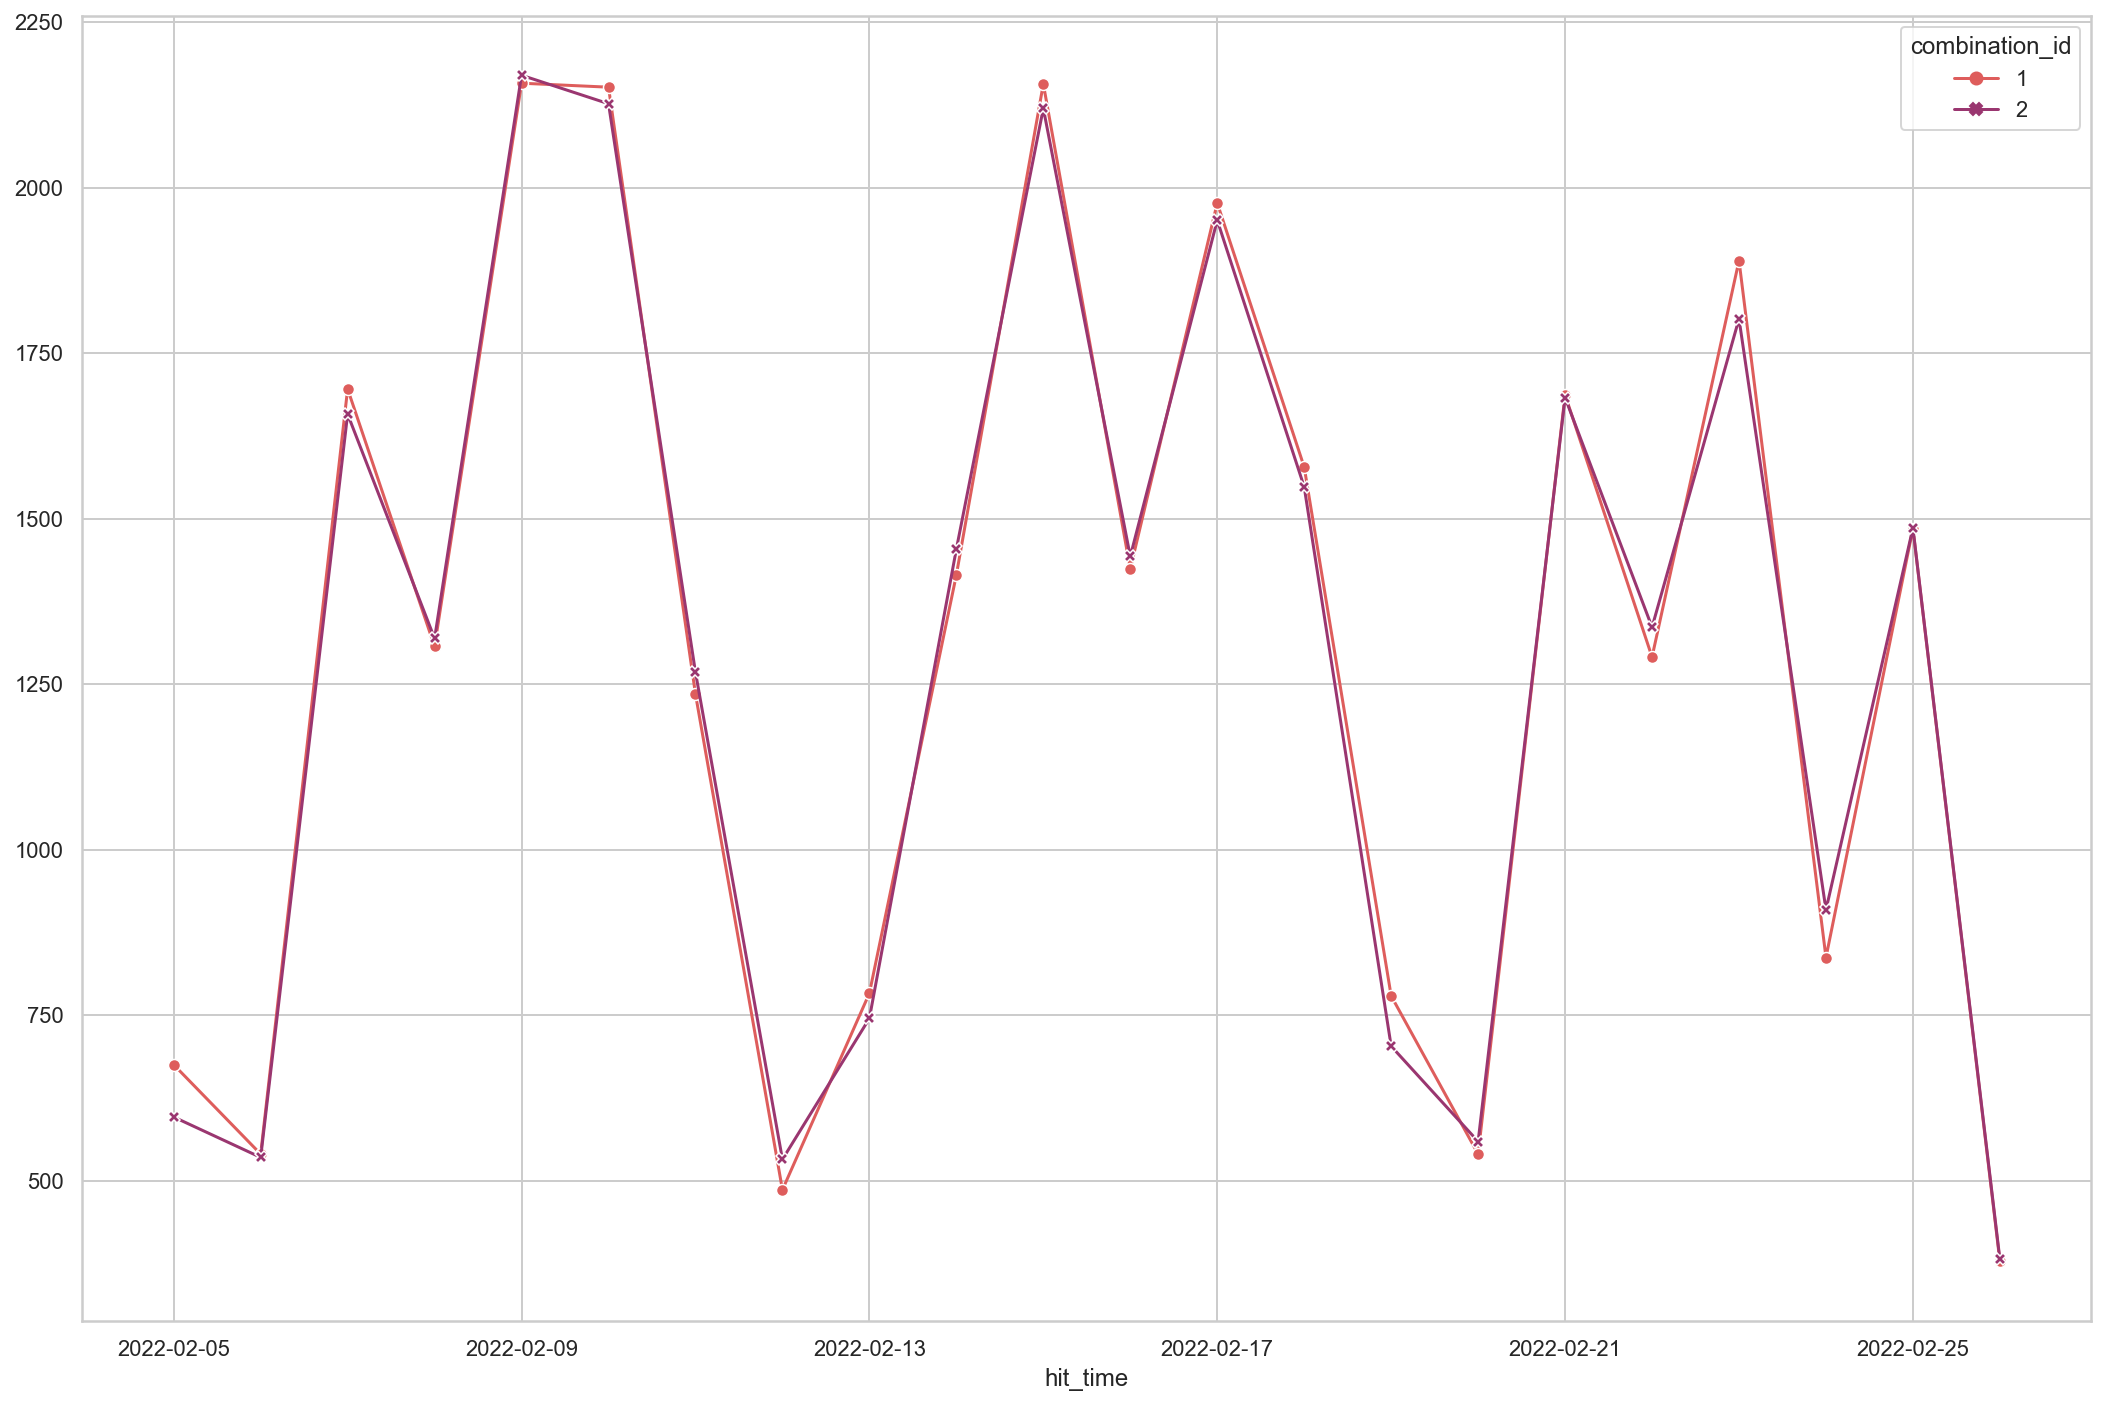

In [78]:
# RESAMPLE BY DAYS

gr = df.groupby([df['hit_time'].dt.date, df.combination_id]).size().unstack()
gr.index = gr.index.astype('datetime64[ns]')

sns.set_theme(style="whitegrid")
timeline = plt.subplots(figsize=(18, 12))
timeline = sns.lineplot(\
                       # height=12,\
                       # aspect=1.5,\
                       data=\
                       # df[df['combination_id']==1].groupby([df['hit_time'].dt.date]).size(),\
                       gr.resample('D').asfreq(),\
                       # kind="line",\
                       linewidth=1.5,\
                       markers=True,\
                       dashes=False,\
                       palette="flare", 
                      )
 


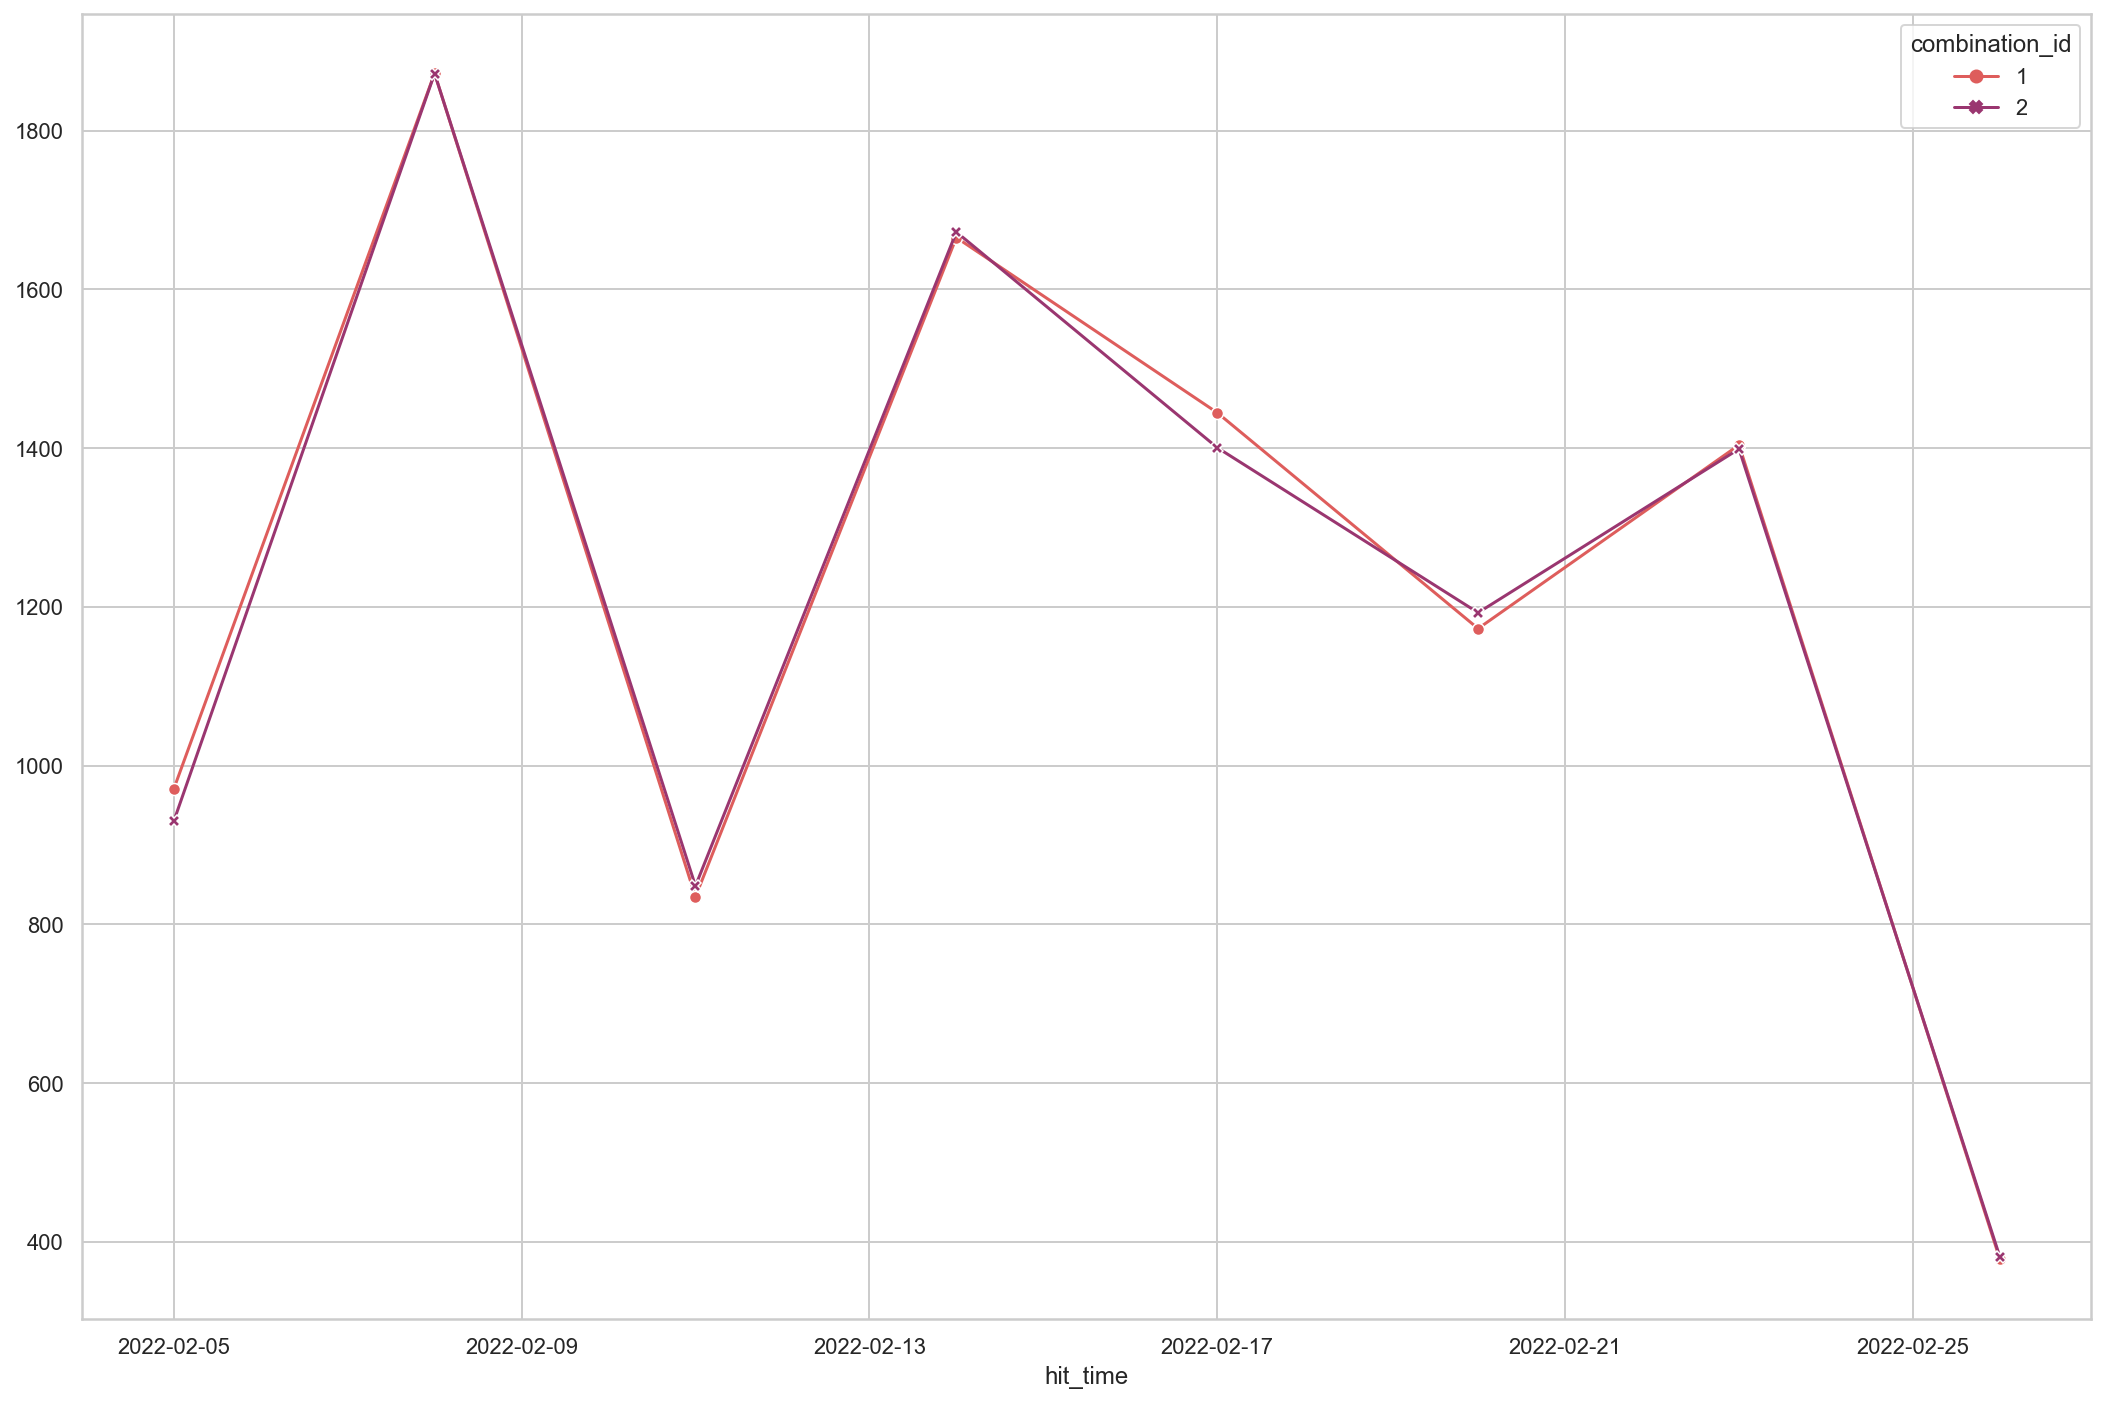

In [79]:
# RESAMPLE BY DAYS

gr = df.groupby([df['hit_time'].dt.date, df.combination_id]).size().unstack()
gr.index = gr.index.astype('datetime64[ns]')

sns.set_theme(style="whitegrid")
timeline = plt.subplots(figsize=(18, 12))
timeline = sns.lineplot(\
                       # height=12,\
                       # aspect=1.5,\
                       data=\
                       # df[df['combination_id']==1].groupby([df['hit_time'].dt.date]).size(),\
                       gr.resample('3D').mean(),\
                       # kind="line",\
                       linewidth=1.5,\
                       markers=True,\
                       dashes=False,\
                       palette="flare", 
                      )
 


variation groups order is [1, 2]


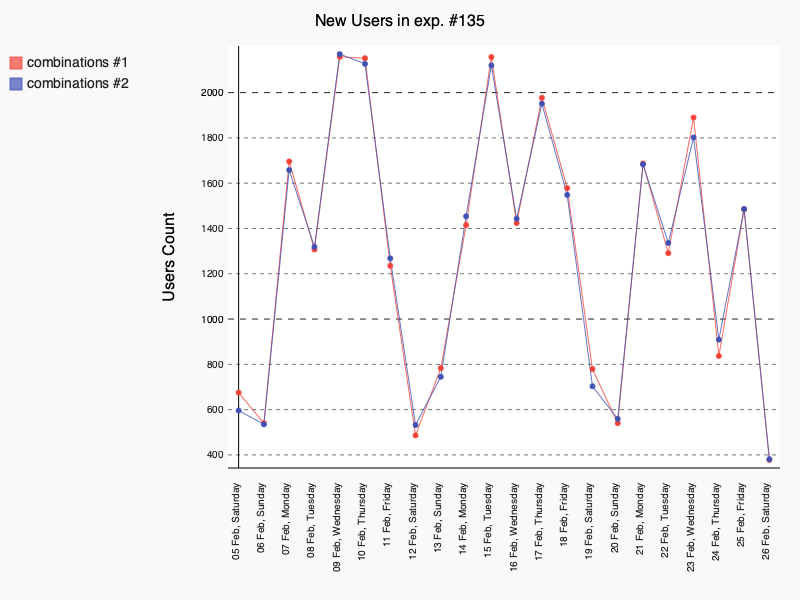

In [80]:
# Draw new user visits on DataTime Scale

factor = list(df['combination_id'].unique())
factor.sort()
date_chart = pygal.Line\
    (
#      fill=True,\
     x_label_rotation=270,\
     x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
     y_title='Users Count')
date_chart.x_labels = df['hit_time'].dt.date.unique()

date_chart.title = 'New Users in exp. #{}'.format(exp)


for x in range(len(factor)):
    viz = date_chart.add('combinations #{}'.format(x+1), list(df[df['combination_id']==factor[x]].groupby([df['hit_time'].dt.date]).size()))
print('variation groups order is', factor)
date_chart

date_chart.render_to_file('/Users/rodiontereshkov/Downloads/new_visitors_exp{}.svg'.format(exp))

variation groups order is [1, 2]


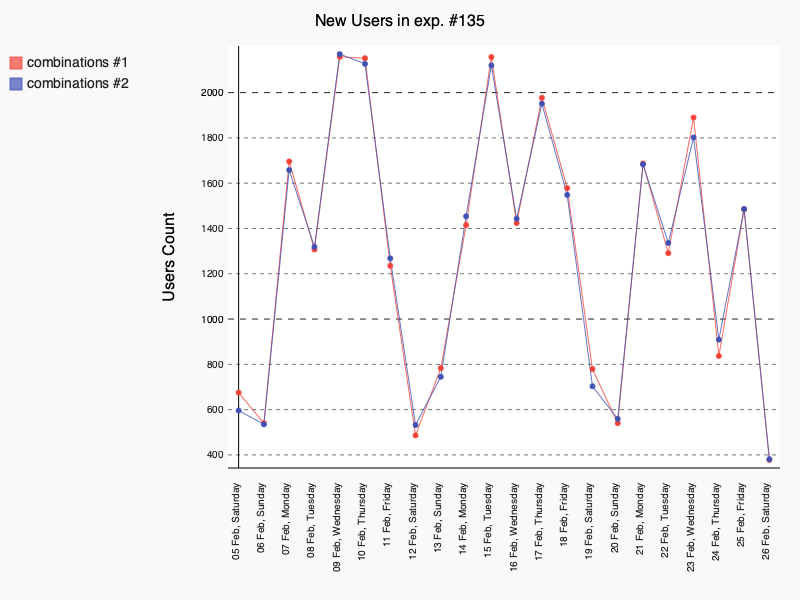

In [36]:
# Draw new user visits on DataTime Scale

factor = list(df['combination_id'].unique())
factor.sort()
date_chart = pygal.Line\
    (
#      fill=True,\
     x_label_rotation=270,\
     x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
     y_title='Users Count')
date_chart.x_labels = df.groupby([df['hit_time'].dt.date]).size().asfreq('D').index

date_chart.title = 'New Users in exp. #{}'.format(exp)


for x in range(len(factor)):
    viz = date_chart.add('combinations #{}'.format(x+1), list(df[df['combination_id']==factor[x]].groupby([df['hit_time'].dt.date]).size()))
print('variation groups order is', factor)
date_chart

date_chart.render_to_file('/Users/rodiontereshkov/Downloads/new_visitors_exp{}.svg'.format(exp))

#### Draw Goals day by day

In [81]:
goal_ids = meta['id'][:-3]

int_goal_ids = []
for goal_id in goal_ids:
    int_goal_ids.append(int(goal_id))

int_goal_ids

[1,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 212]

variation groups order is [1, 2]


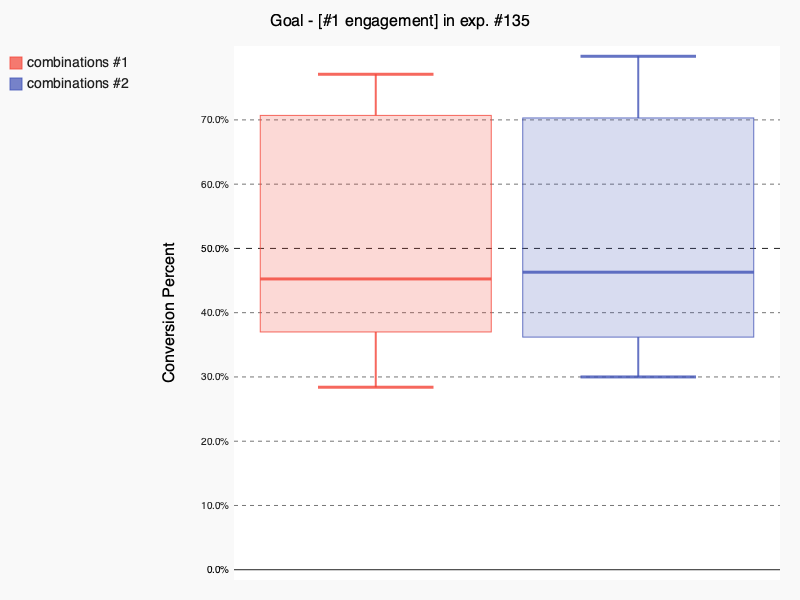

variation groups order is [1, 2]


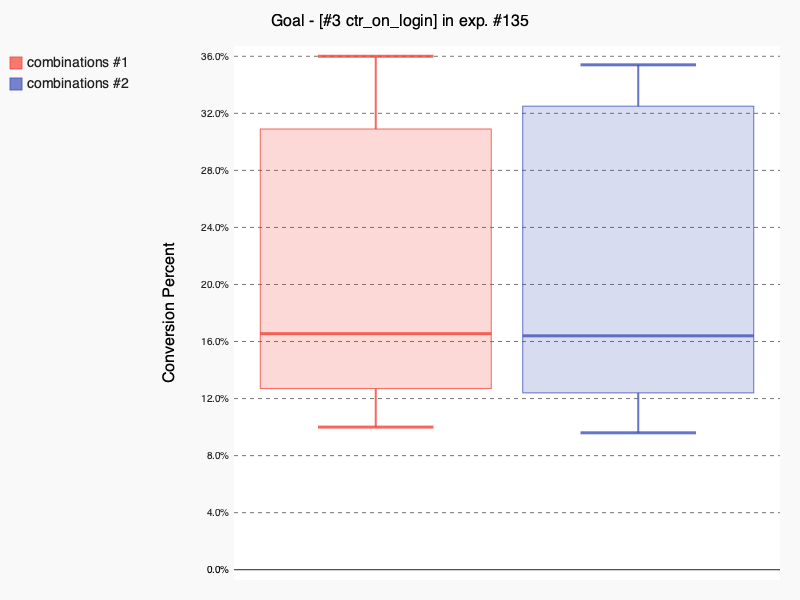

variation groups order is [1, 2]


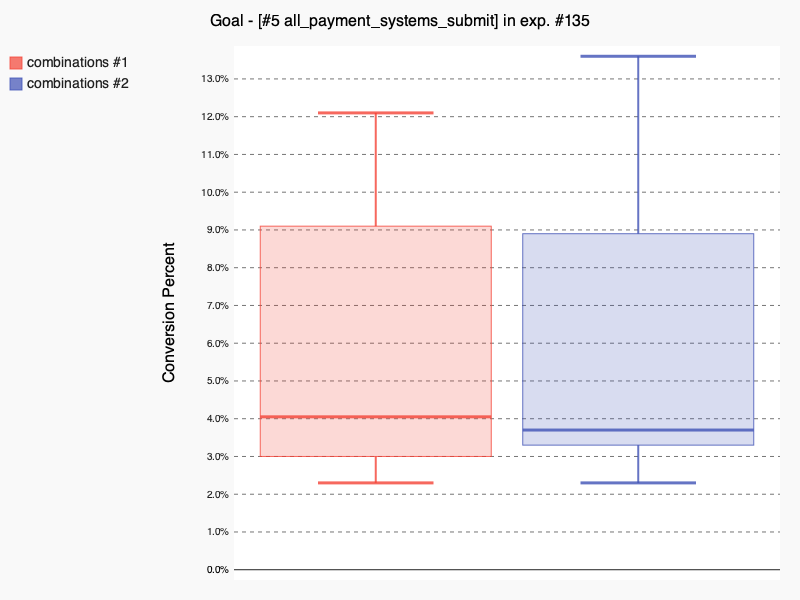

variation groups order is [1, 2]


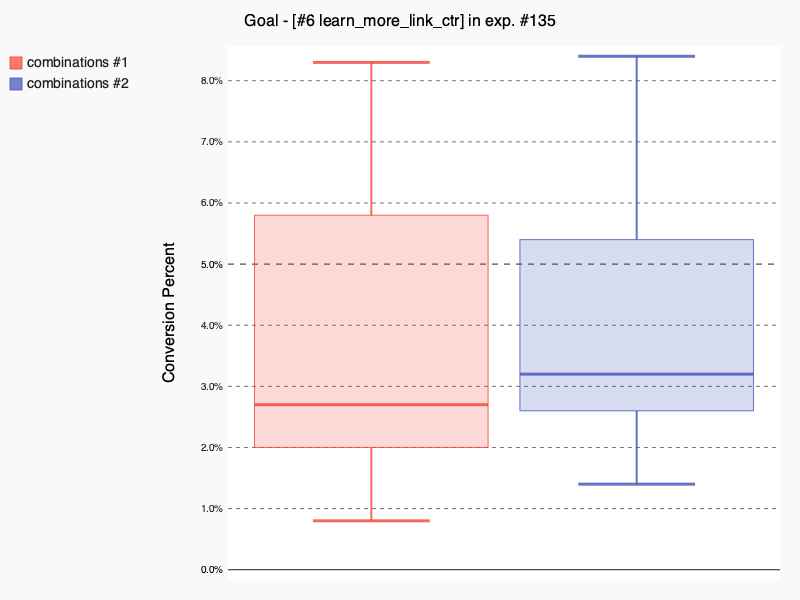

variation groups order is [1, 2]


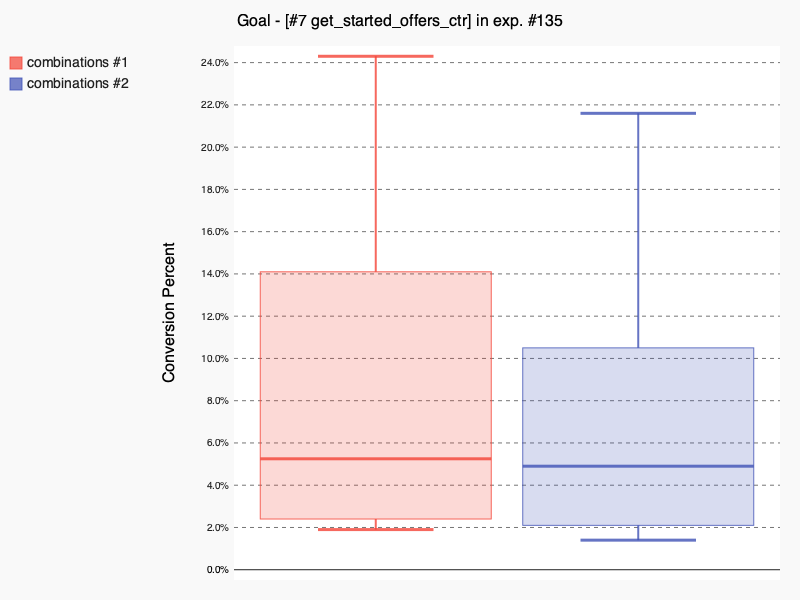

variation groups order is [1, 2]


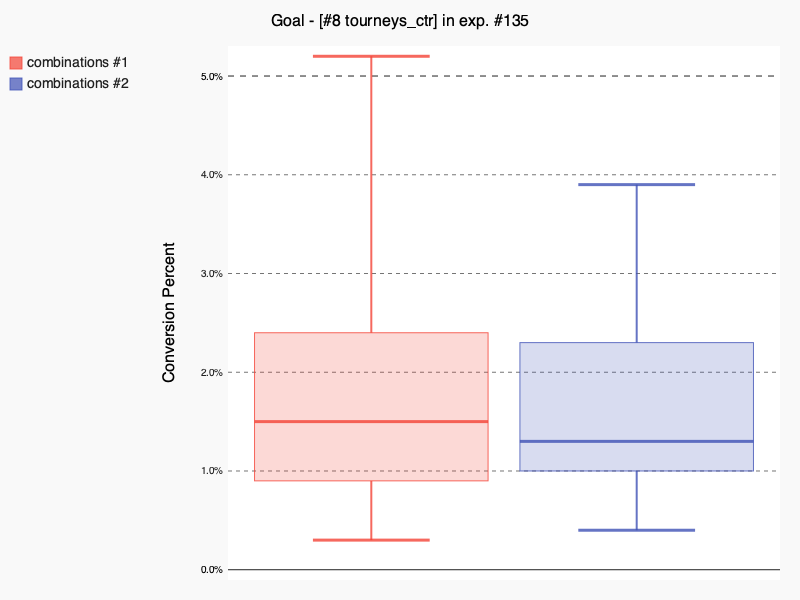

variation groups order is [1, 2]


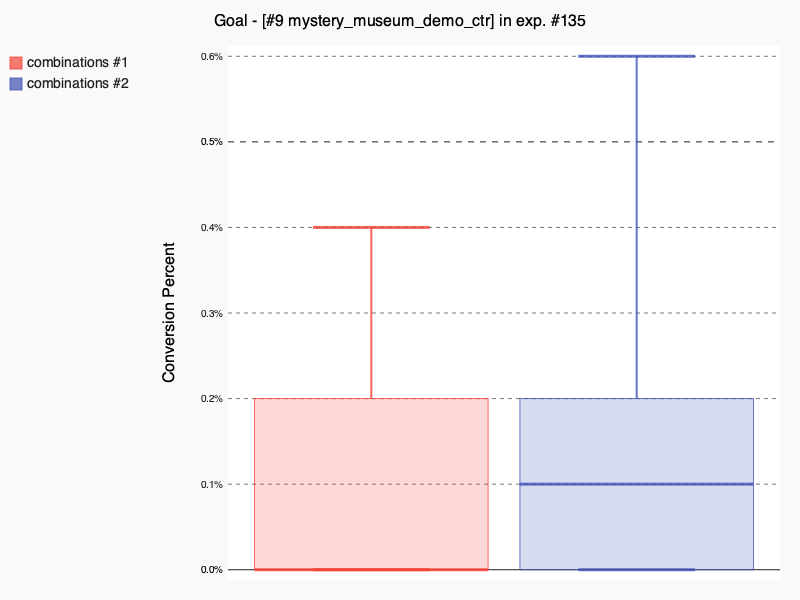

variation groups order is [1, 2]


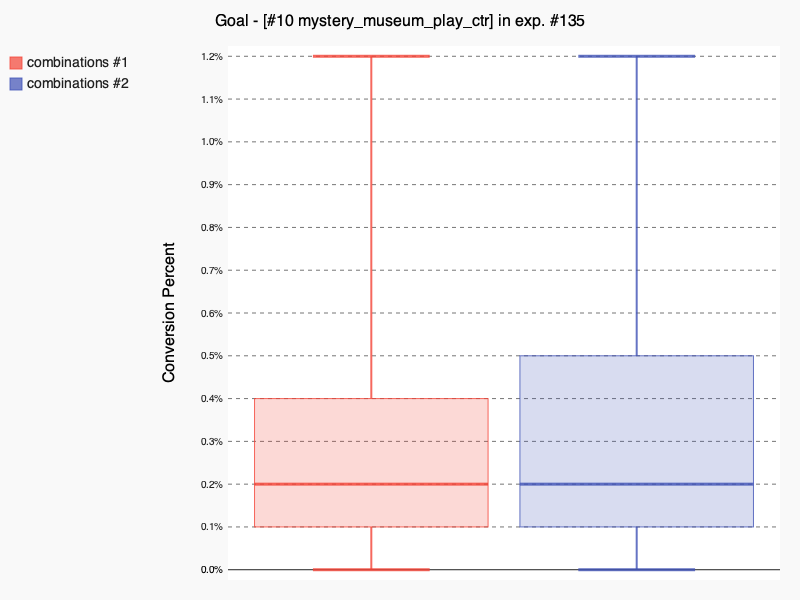

variation groups order is [1, 2]


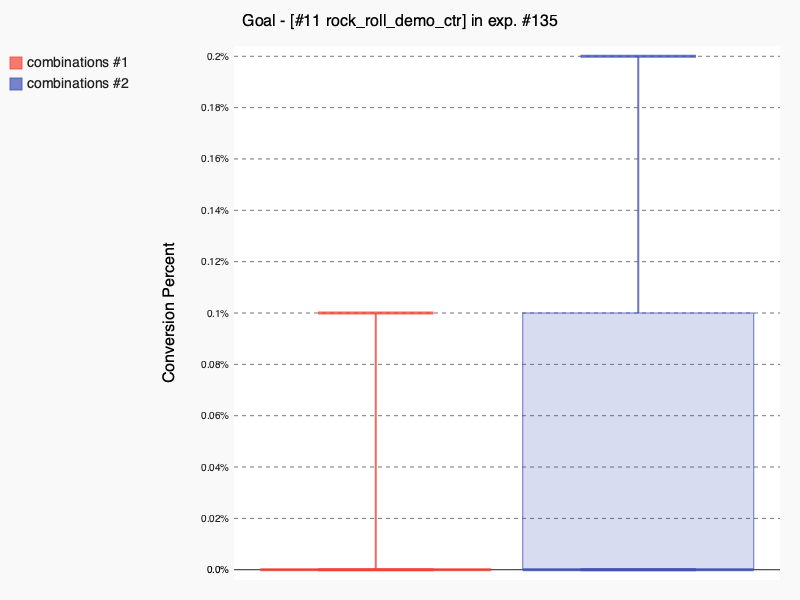

variation groups order is [1, 2]


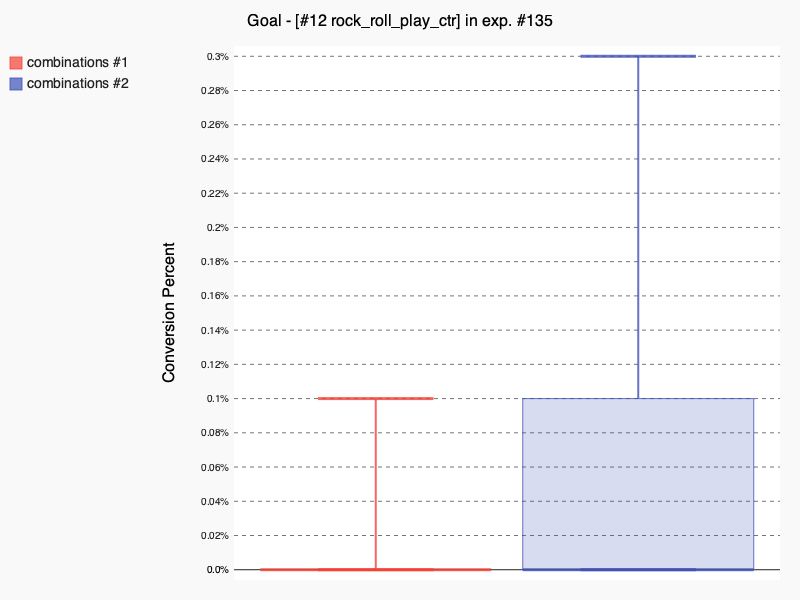

variation groups order is [1, 2]


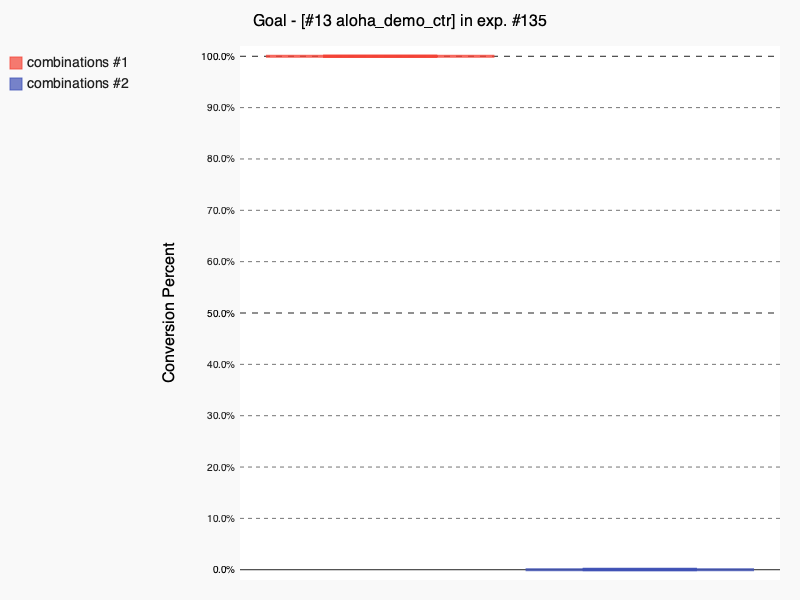

variation groups order is [1, 2]


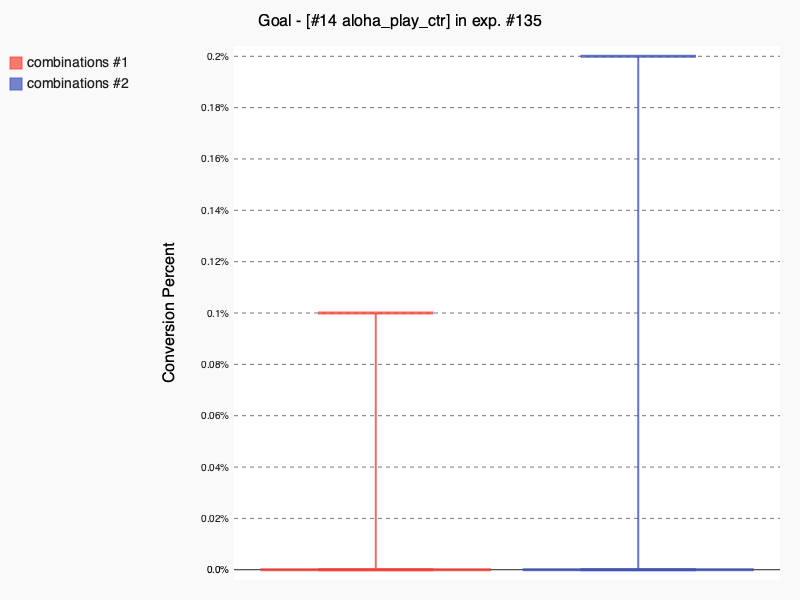

variation groups order is [1, 2]


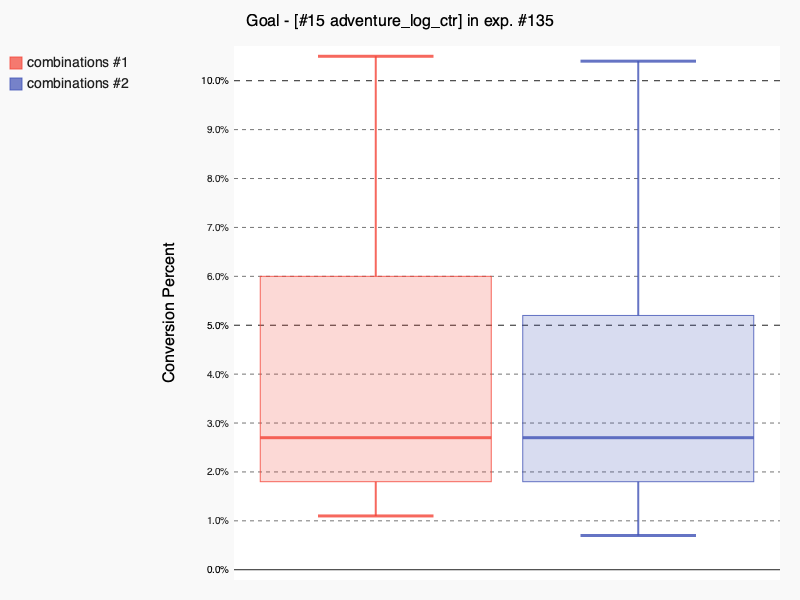

variation groups order is [1, 2]


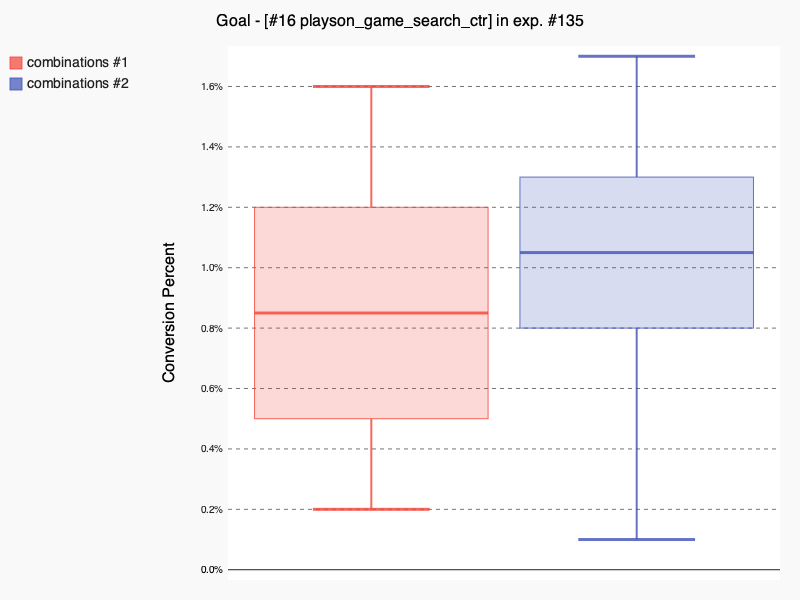

variation groups order is [1, 2]


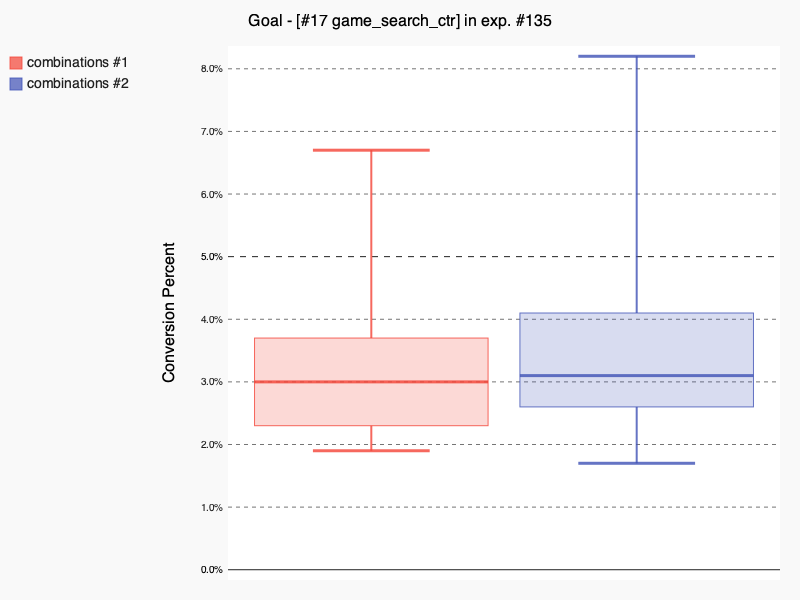

variation groups order is [1, 2]


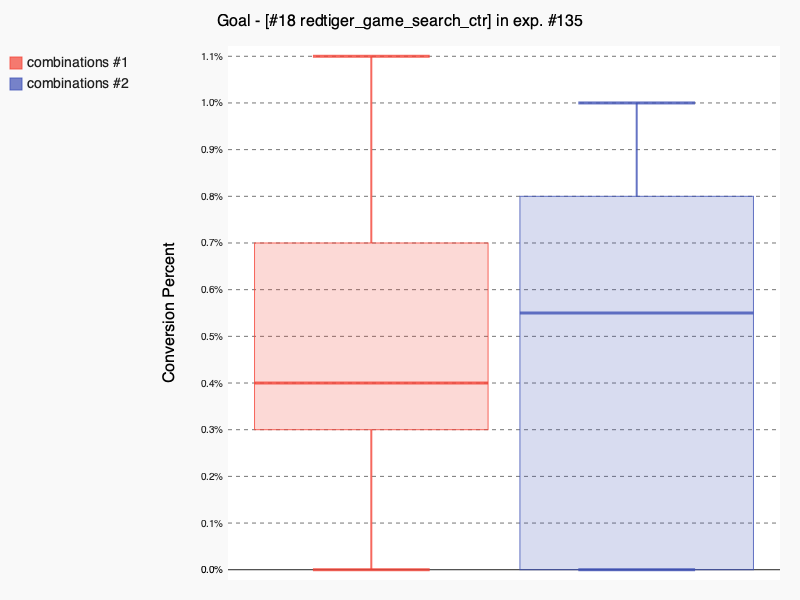

variation groups order is [1, 2]


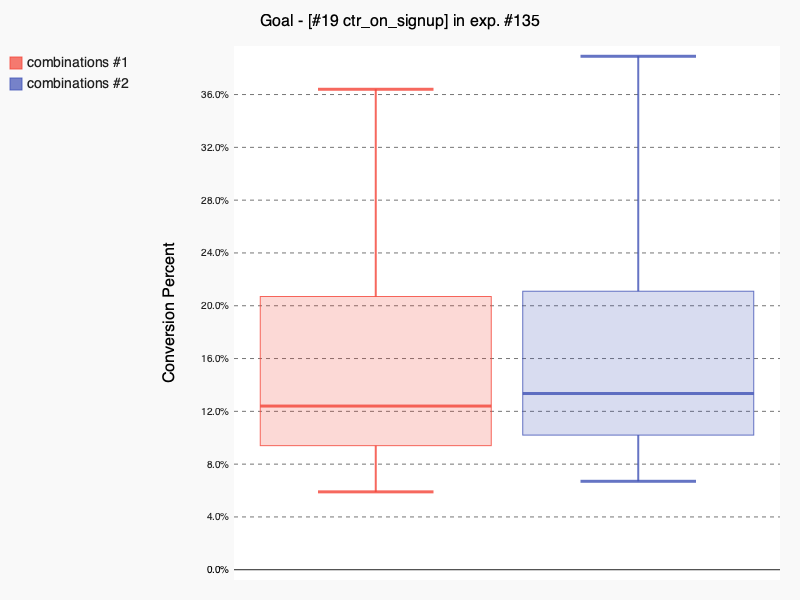

variation groups order is [1, 2]


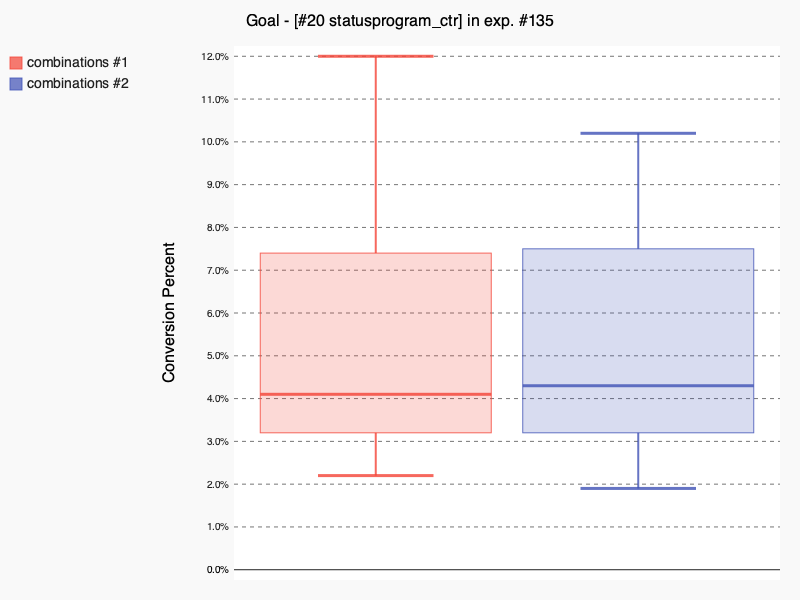

variation groups order is [1, 2]


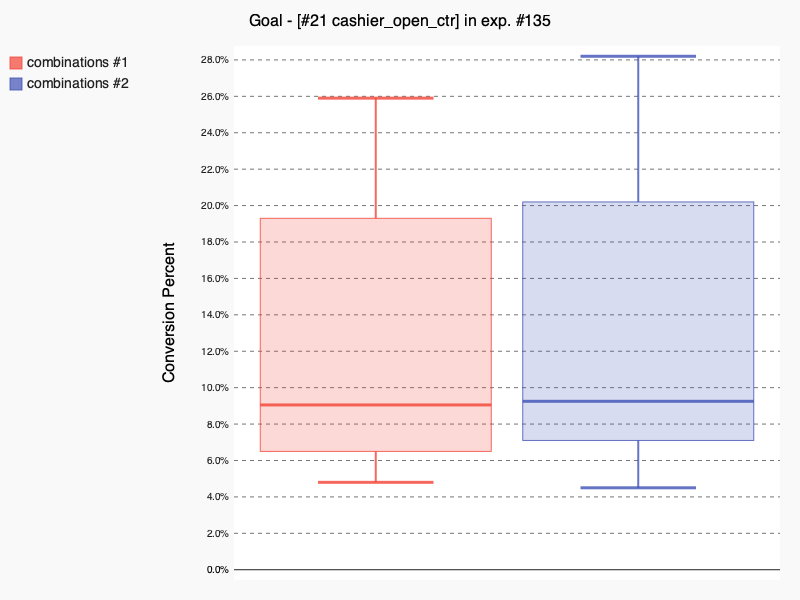

variation groups order is [1, 2]


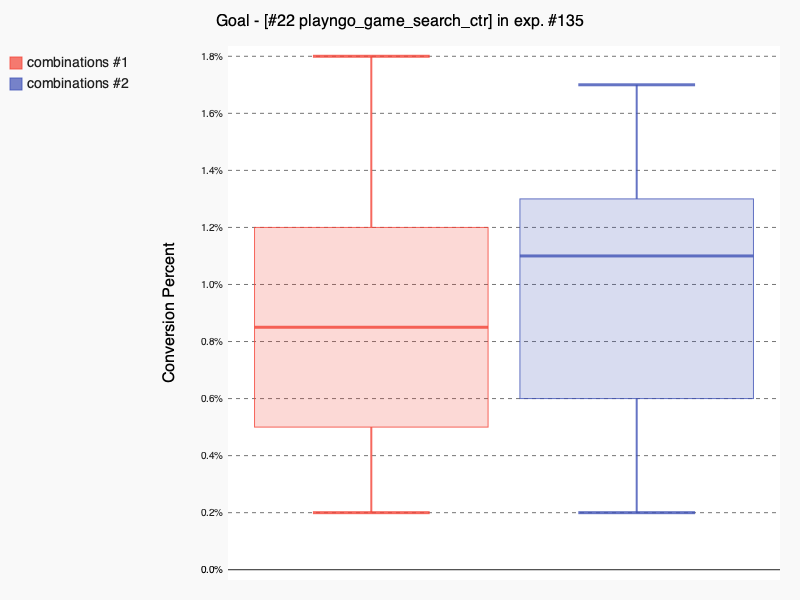

variation groups order is [1, 2]


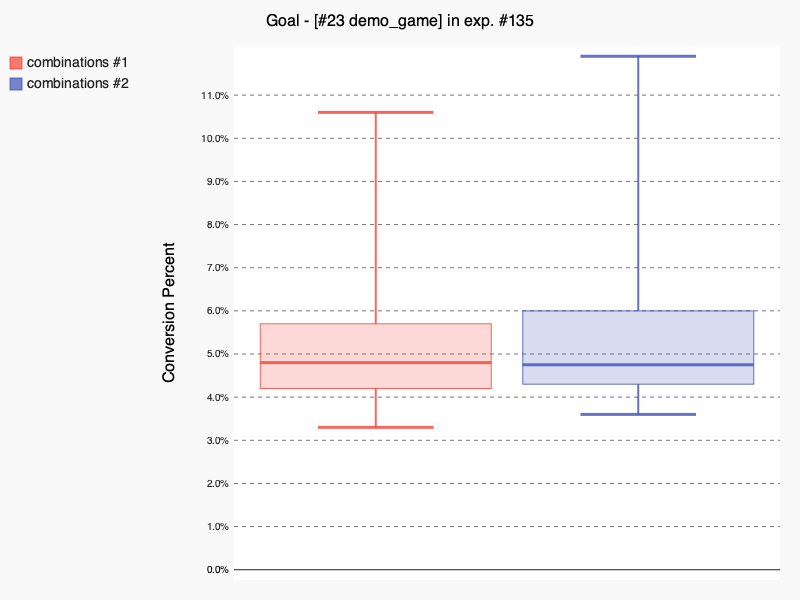

variation groups order is [1, 2]


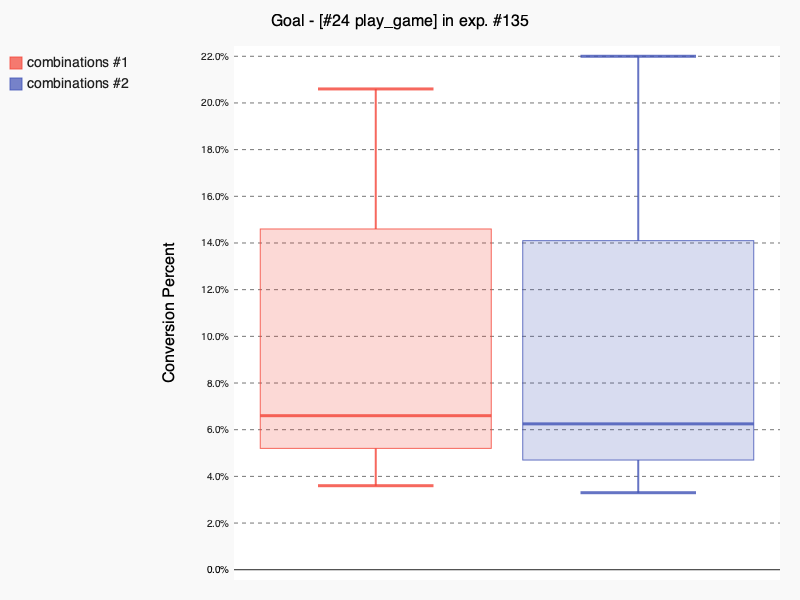

variation groups order is [1, 2]


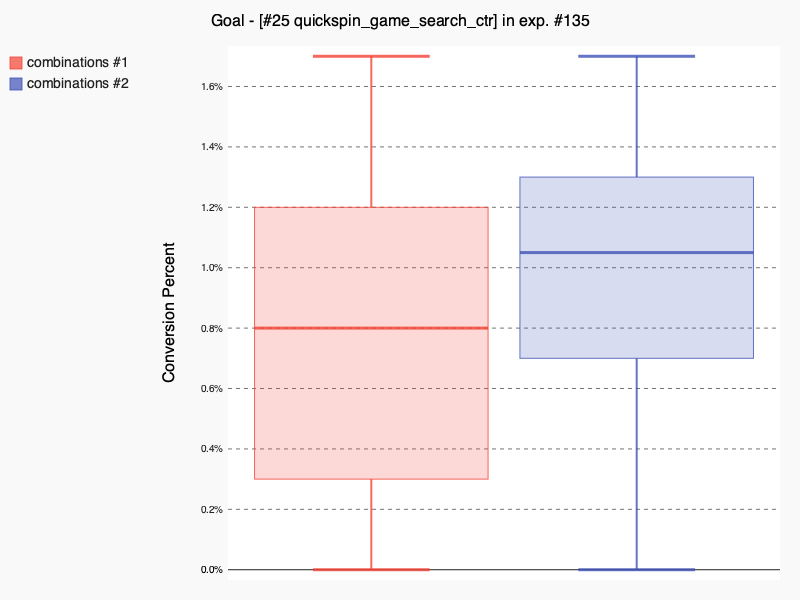

variation groups order is [1, 2]


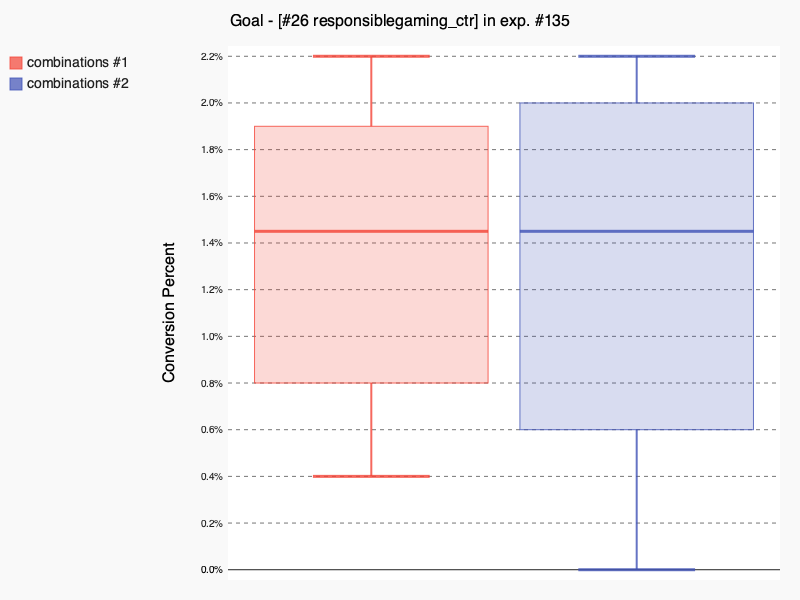

variation groups order is [1, 2]


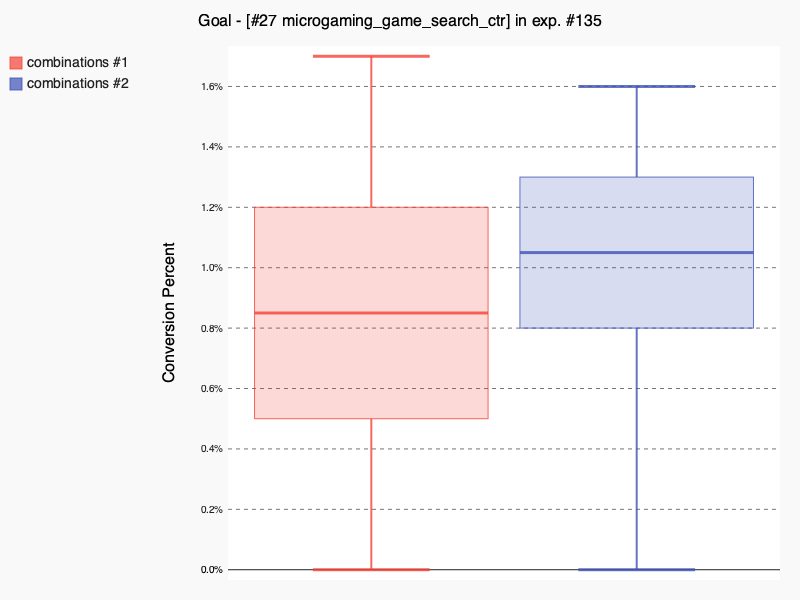

variation groups order is [1, 2]


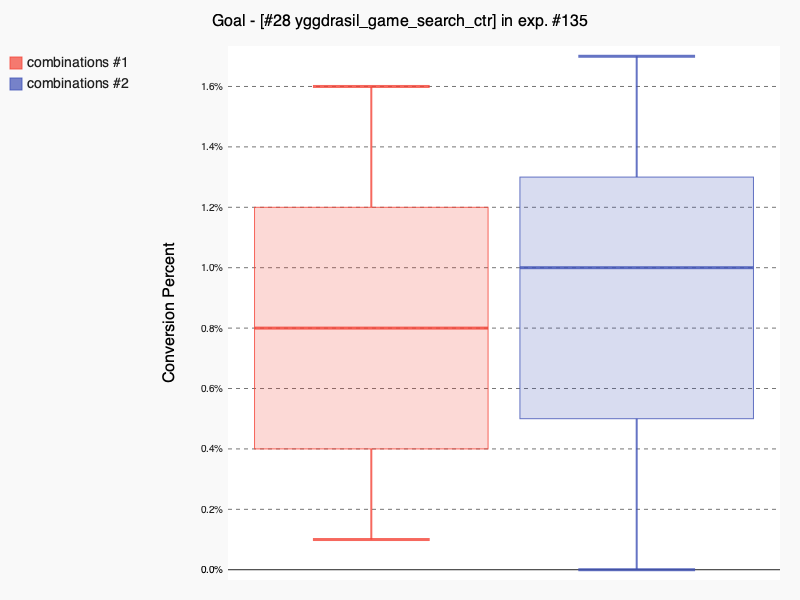

variation groups order is [1, 2]


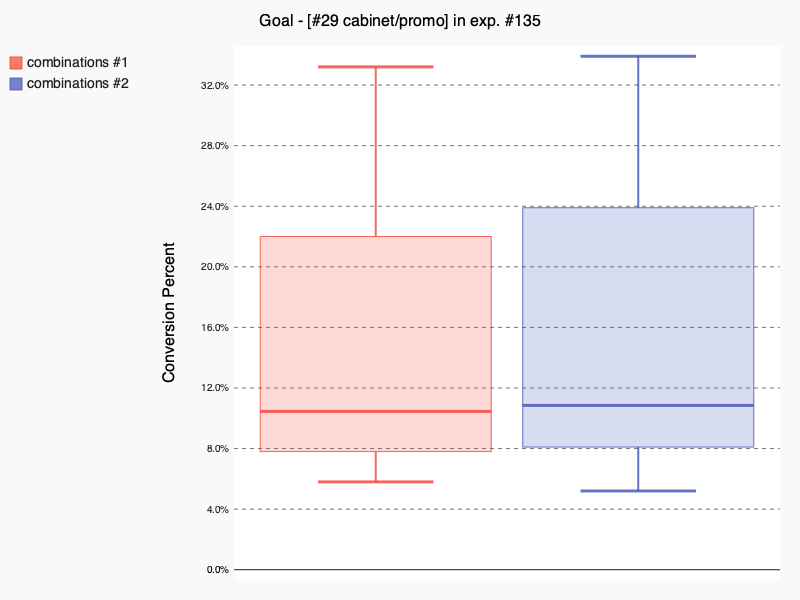

variation groups order is [1, 2]


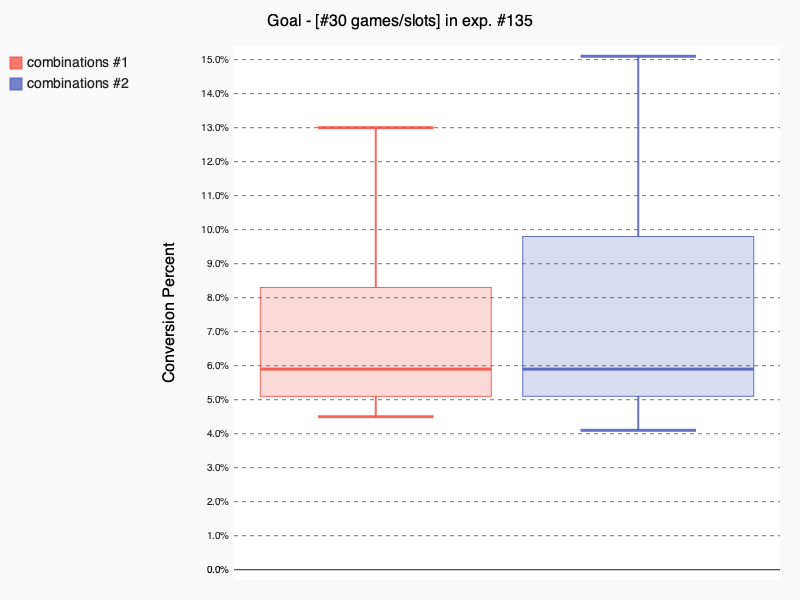

variation groups order is [1, 2]


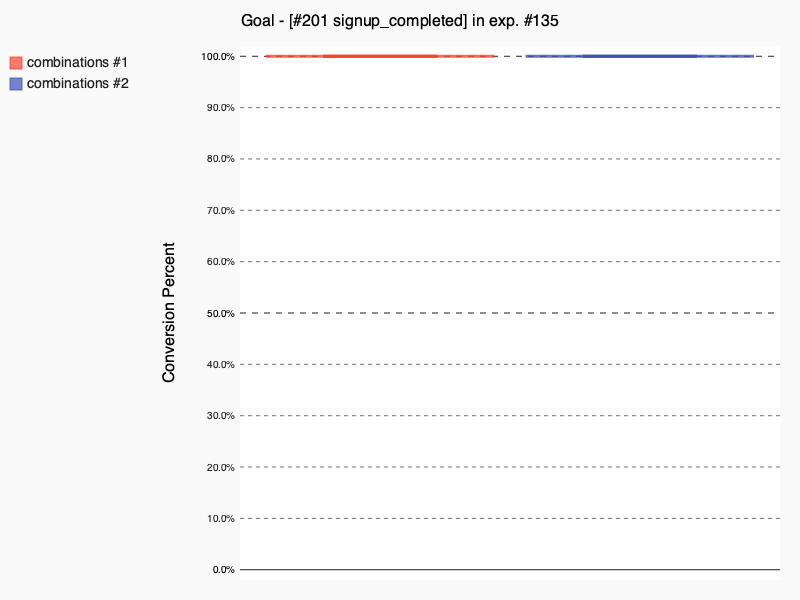

variation groups order is [1, 2]


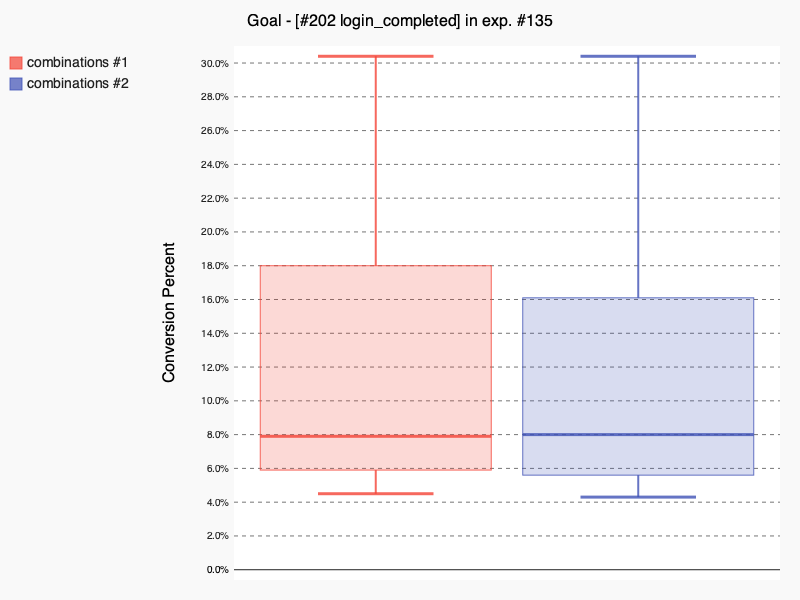

variation groups order is [1, 2]


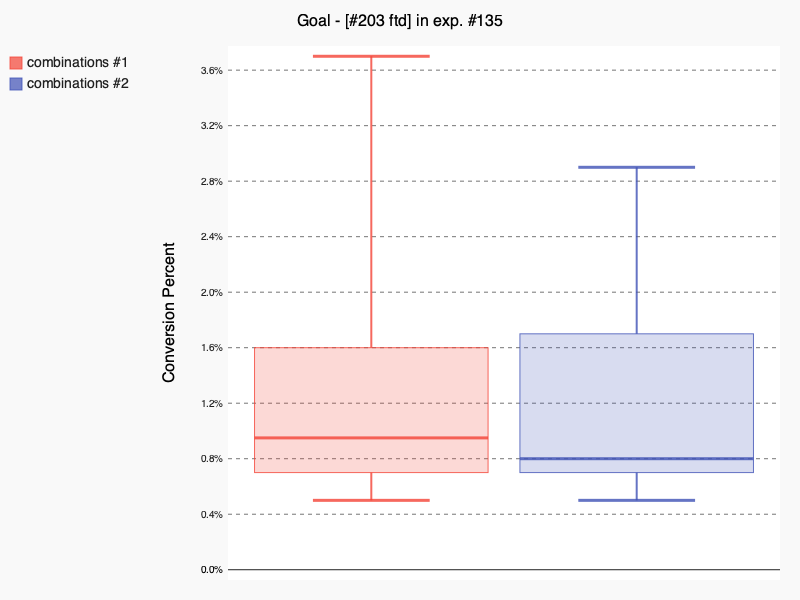

variation groups order is [1, 2]


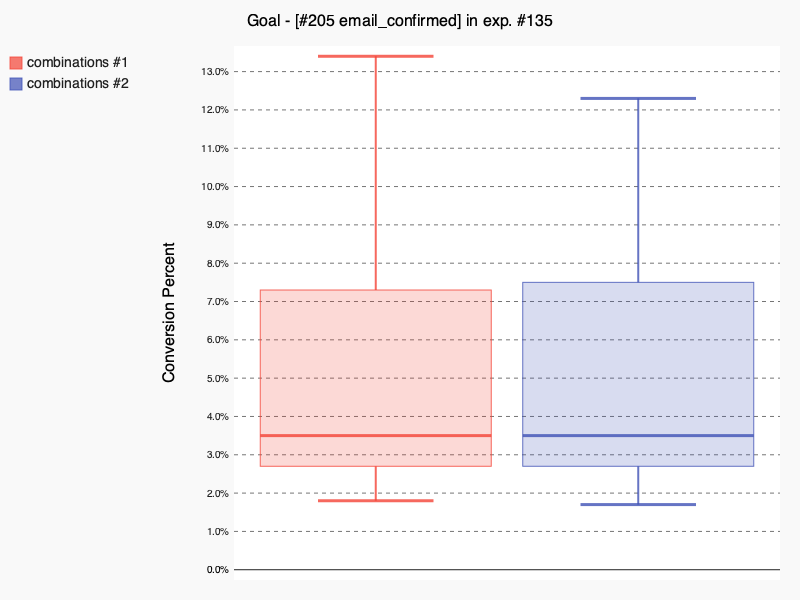

variation groups order is [1, 2]


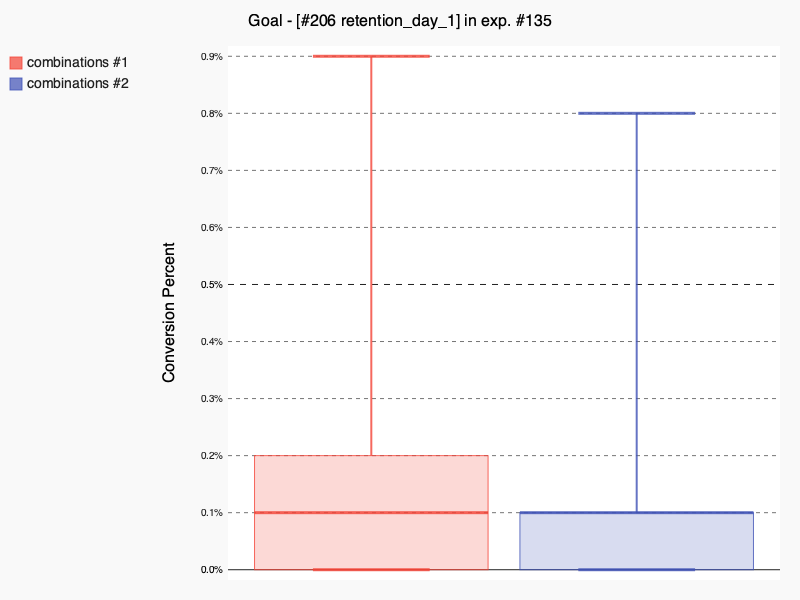

variation groups order is [1, 2]


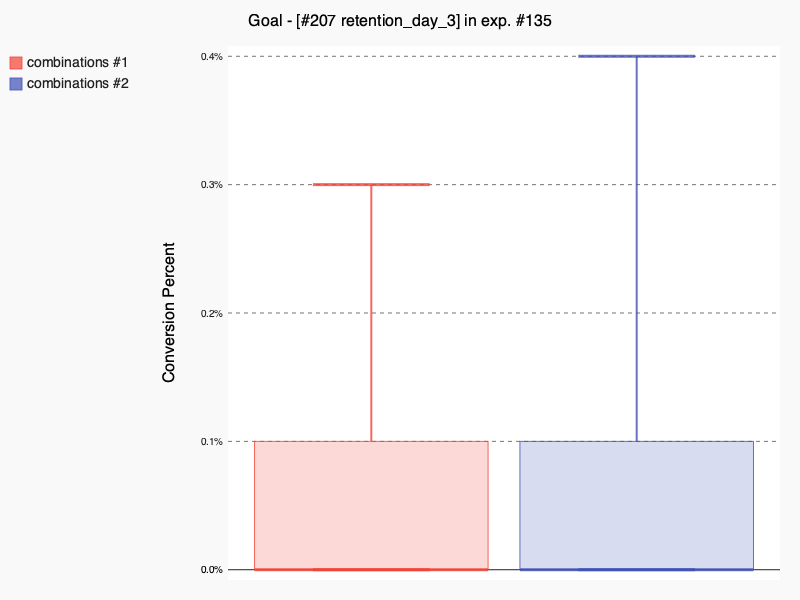

variation groups order is [1, 2]


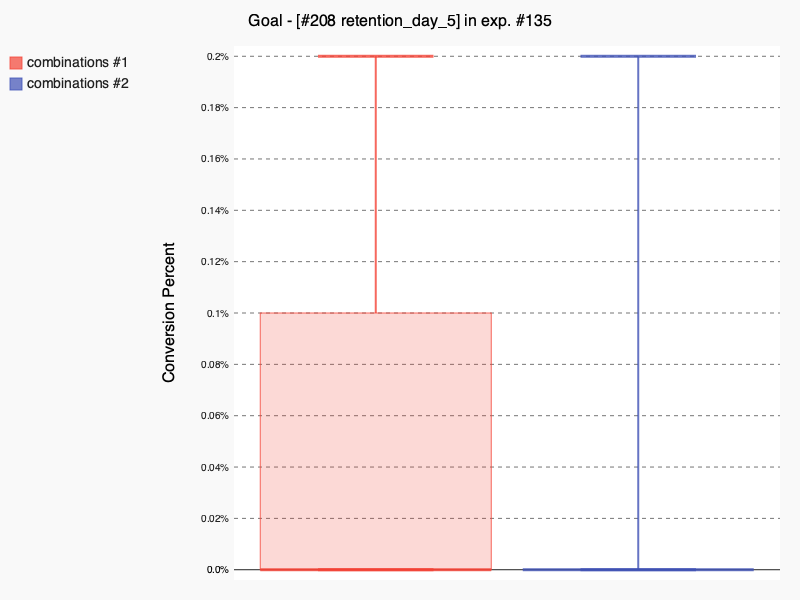

variation groups order is [1, 2]


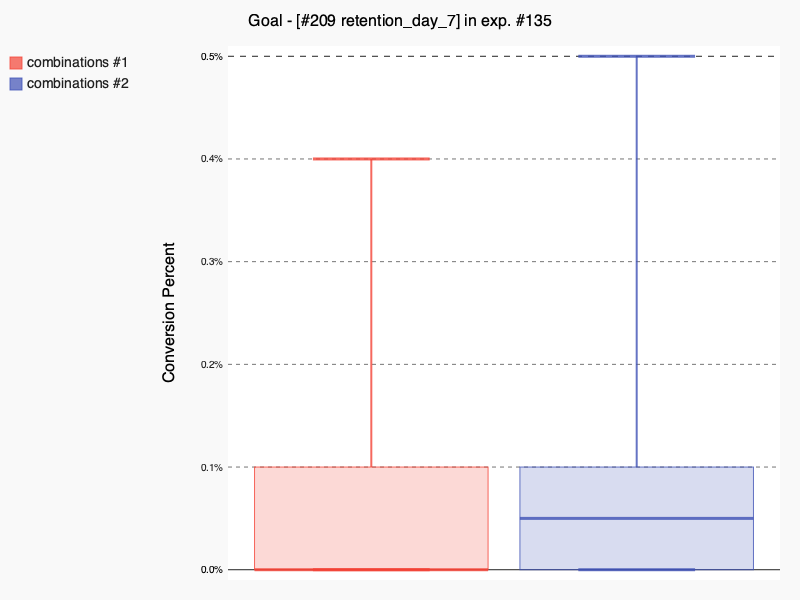

variation groups order is [1, 2]


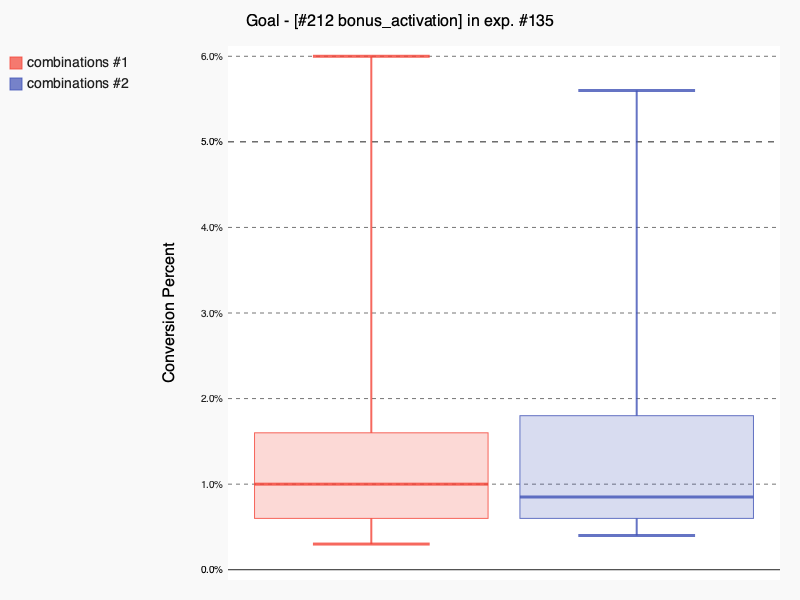

In [38]:
# Draw new user visits on DataTime Scale
goal_ids = meta['id'][:-3]

for int_goal_id in int_goal_ids:
    goal_name = meta[meta['id']==int_goal_id].name.values[0]
    factor = list(df['combination_id'].unique())
    factor.sort()
    date_chart = pygal.Box\
        (\
         fill=True,\
         x_label_rotation=270,\
         x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
         value_formatter = lambda x:'{}%'.format(round(x*100, 4)),\
         y_title='Conversion Percent')
#     date_chart.x_labels = df['hit_time'].dt.date.unique()
    date_chart.title = 'Goal - [#{} {}] in exp. #{}'.format(int_goal_id, goal_name, exp)


    for x in range(len(factor)):
        viz = date_chart.add('combinations #{}'.format(x+1),
                             list(df[df['combination_id']==factor[x]]\
                                  .groupby([df['hit_time'].dt.date])\
                                  ['goal_{}_converted'.format(int_goal_id)].value_counts(normalize=True).unstack().iloc[:, -1].fillna(0).round(3)))
    print('variation groups order is', factor)
    date_chart
    # date_chart.render_to_file('/Users/rodiontereshkov/Downloads/goal_{}_exp_{}_{}.svg'.format(goal_id, exp, today))

## CORRELATION ANALYSIS

In [31]:
meta

category   id                         name               type  \
0          goal    1                   engagement         engagement   
1          goal    3                 ctr_on_login          clickLink   
2          goal    5   all_payment_systems_submit       clickElement   
3          goal    6          learn_more_link_ctr          visitPage   
4          goal    7       get_started_offers_ctr          visitPage   
5          goal    8                 tourneys_ctr          visitPage   
6          goal    9      mystery_museum_demo_ctr          visitPage   
7          goal   10      mystery_museum_play_ctr          visitPage   
8          goal   11           rock_roll_demo_ctr          visitPage   
9          goal   12           rock_roll_play_ctr          visitPage   
10         goal   13               aloha_demo_ctr          visitPage   
11         goal   14               aloha_play_ctr          visitPage   
12         goal   15            adventure_log_ctr          visitPage   
13         goal   16      playson_game_search_ctr          visitPage   
14         goal   17              game_search_ctr          visitPage   
15         goal   18     redtiger_game_search_ctr          visitPage   
16         goal   19                ctr_on_signup          visitPage   
17         goal   20            statusprogram_ctr          visitPage   
18         goal   21             cashier_open_ctr          visitPage   
19         goal   22      playngo_game_search_ctr          visitPage   
20         goal   23                    demo_game          visitPage   
21         goal   24                    play_game          visitPage   
22         goal   25    quickspin_game_search_ctr          visitPage   
23         goal   26        responsiblegaming_ctr          visitPage   
24         goal   27  microgaming_game_search_ctr          visitPage   
25         goal   28    yggdrasil_game_search_ctr          visitPage   
26         goal   29                cabinet/promo          visitPage   
27         goal   30                  games/slots          visitPage   
28         goal  201             signup_completed  custom-conversion   
29         goal  202              login_completed  custom-conversion   
30         goal  203                          ftd  custom-conversion   
31         goal  205              email_confirmed  custom-conversion   
32         goal  206              retention_day_1  custom-conversion   
33         goal  207              retention_day_3  custom-conversion   
34         goal  208              retention_day_5  custom-conversion   
35         goal  209              retention_day_7  custom-conversion   
36         goal  212             bonus_activation  custom-conversion   
37  combination    1                      Control                NaN   
38  combination    2                  Variation 1                NaN   
39     campaign  135                      Stories                NaN   

      created_timestamp  info  
0   2021-11-18 10:26:51   NaN  
1   2021-11-18 10:26:51   NaN  
2   2021-11-18 10:26:51   NaN  
3   2022-02-03 19:51:59   NaN  
4   2022-02-03 19:53:19   NaN  
5   2022-02-03 19:54:25   NaN  
6   2022-02-03 19:56:33   NaN  
7   2022-02-03 19:56:33   NaN  
8   2022-02-03 19:57:39   NaN  
9   2022-02-03 19:58:27   NaN  
10  2022-02-03 19:59:52   NaN  
11  2022-02-03 19:59:52   NaN  
12  2022-02-03 20:00:49   NaN  
13  2022-02-03 20:24:14   NaN  
14  2022-02-03 20:24:14   NaN  
15  2022-02-03 20:27:00   NaN  
16  2022-02-03 20:28:10   NaN  
17  2022-02-03 20:30:49   NaN  
18  2022-02-03 20:36:11   NaN  
19  2022-02-03 20:40:49   NaN  
20  2022-02-03 20:46:26   NaN  
21  2022-02-03 20:46:26   NaN  
22  2022-02-03 20:59:29   NaN  
23  2022-02-03 21:01:58   NaN  
24  2022-02-03 21:03:12   NaN  
25  2022-02-03 21:04:19   NaN  
26  2022-02-03 21:08:03   NaN  
27  2022-02-03 21:08:38   NaN  
28  2021-11-18 10:26:51   NaN  
29  2022-02-03 20:34:38   NaN  
30  2021-11-18 10:26:51   NaN  
31  2021-11-18 10:26:51   NaN 

In [40]:
converted = list(df.columns[df.columns.str.endswith('_converted')])
unwanted = ['goal_206_converted','goal_207_converted',]
converted = [elem for elem in converted  if elem not in unwanted]

Text(0.5, 1.0, 'CORRELATION ANALYSIS for ALL GROUPS TOGETHER')

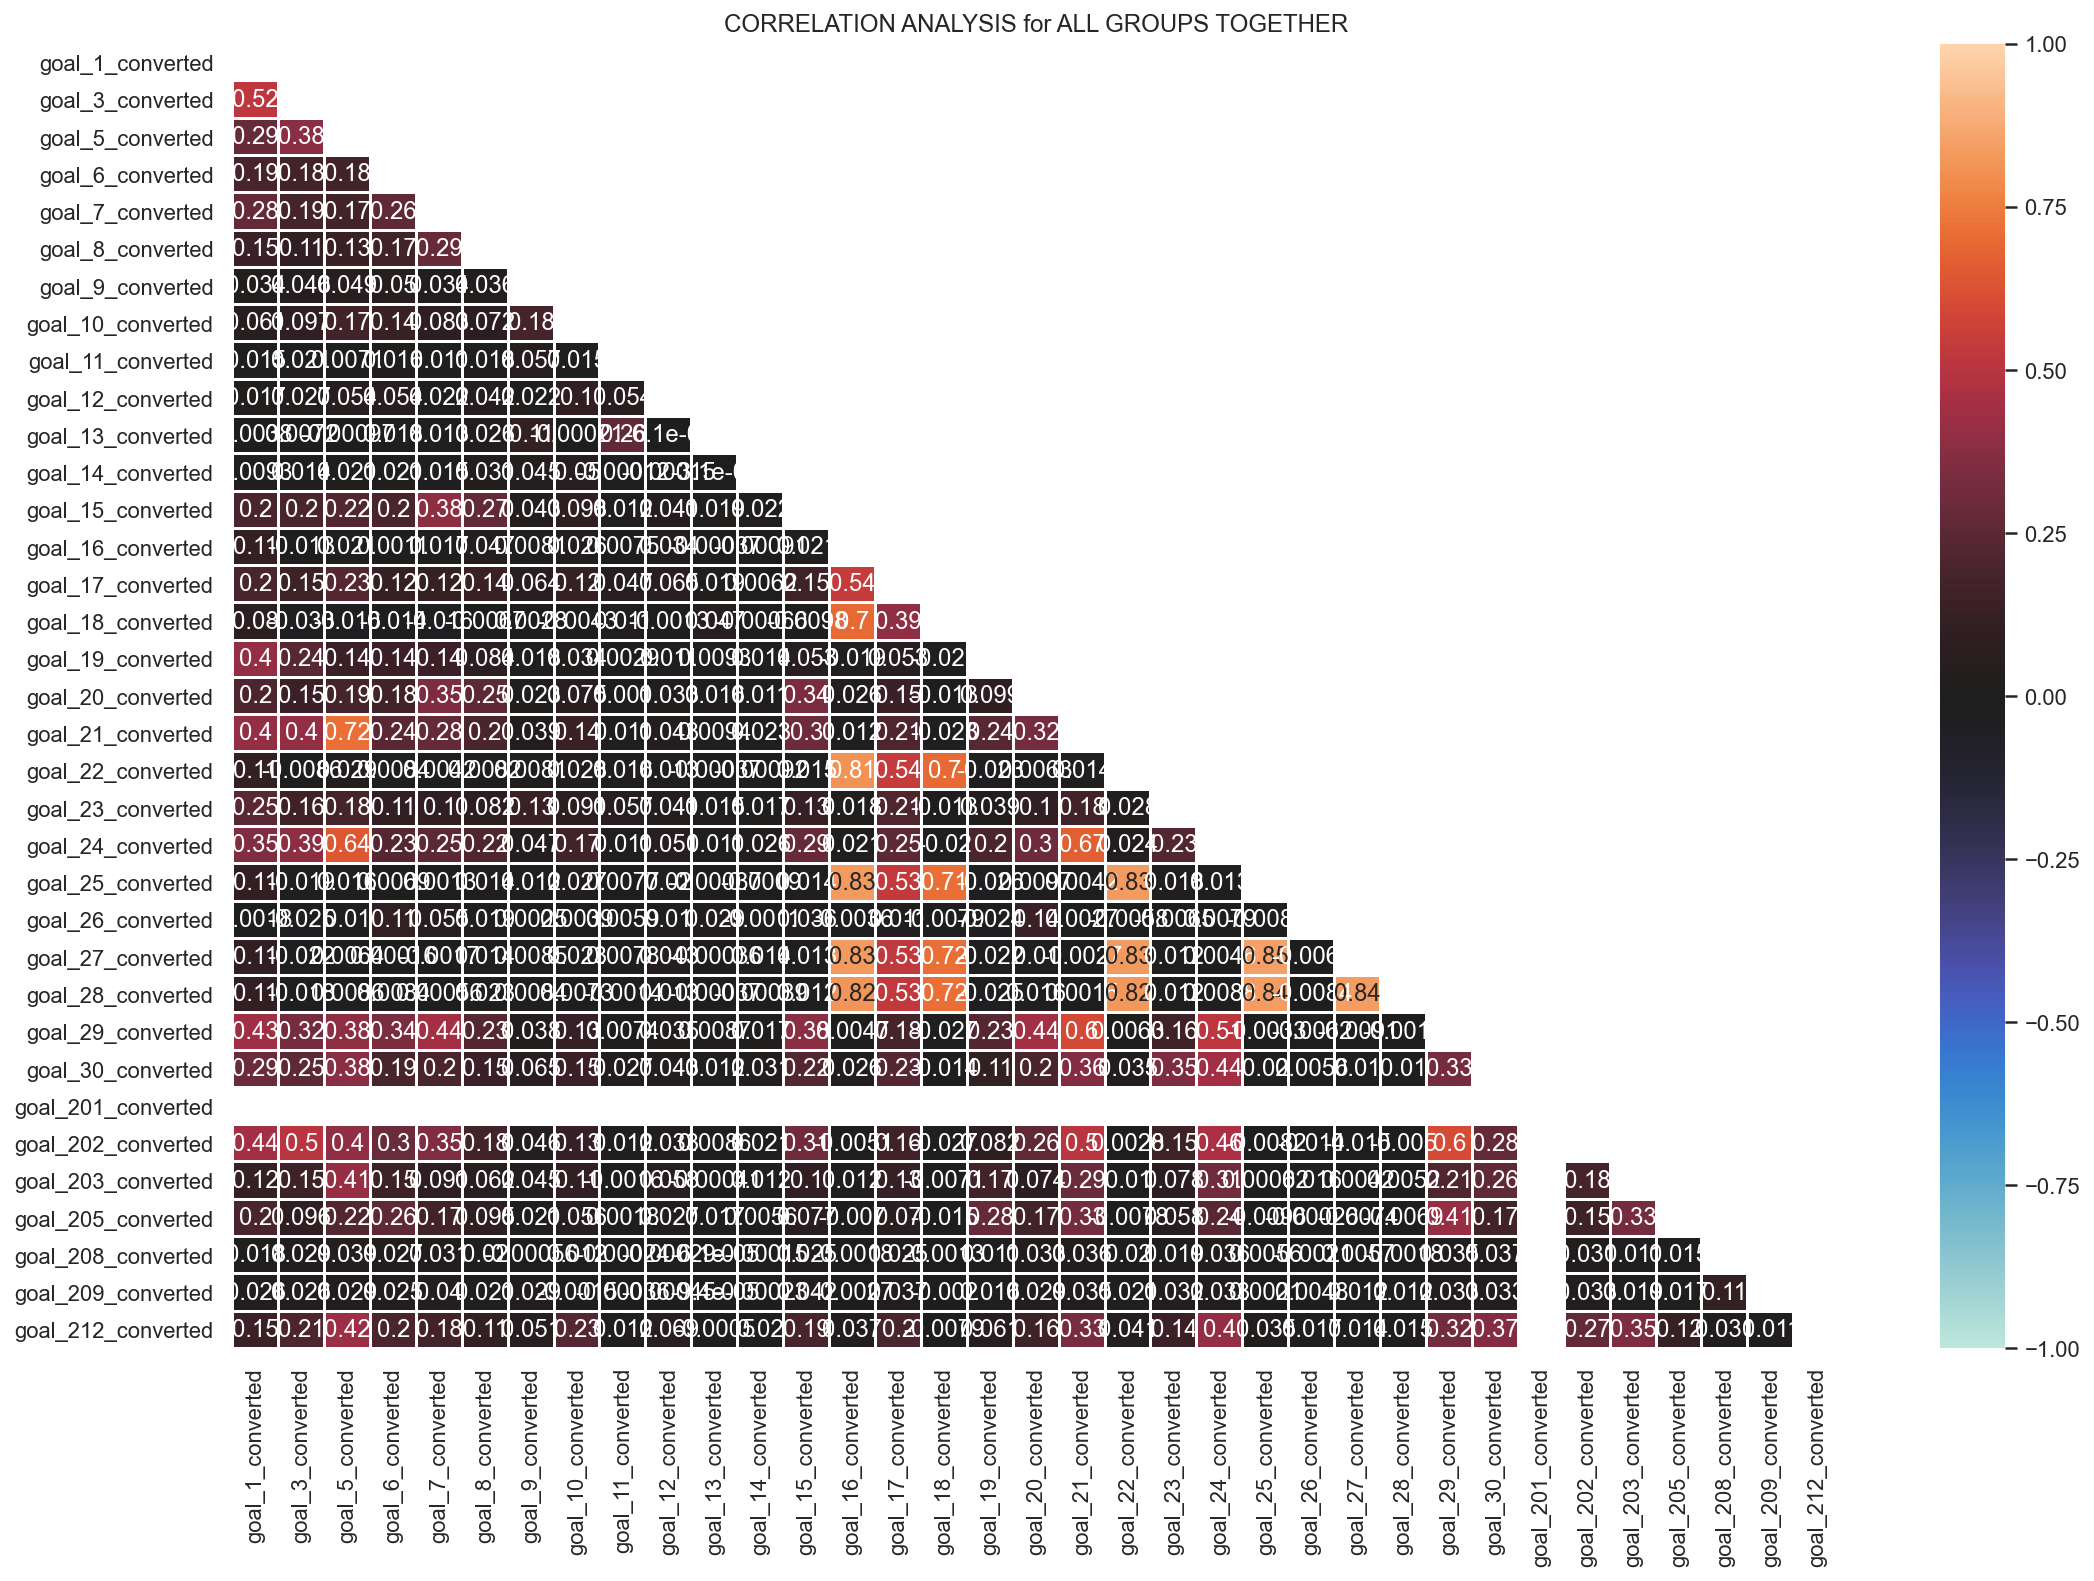

In [83]:
corr_new = df_goals[converted].corr()
mask = np.zeros_like(corr_new)
mask[np.triu_indices_from(mask)] = True

ax_nulls = plt.subplots(figsize=(18, 12))
ax_nulls = plt.subplot(111)
ax_nulls = sns.heatmap(corr_new,\
                      mask=mask,\
                      vmin=-1, vmax=1, annot=True, linewidths=1, center=0
                      )

ax_nulls.set_title('CORRELATION ANALYSIS for ALL GROUPS TOGETHER')

#### CORRELATION FOR EACH GROUP SEPARATELY

Text(0.5, 1.0, 'CORRELATION ANALYSIS for GROUP #1')

Text(0.5, 1.0, 'CORRELATION ANALYSIS for GROUP #2')

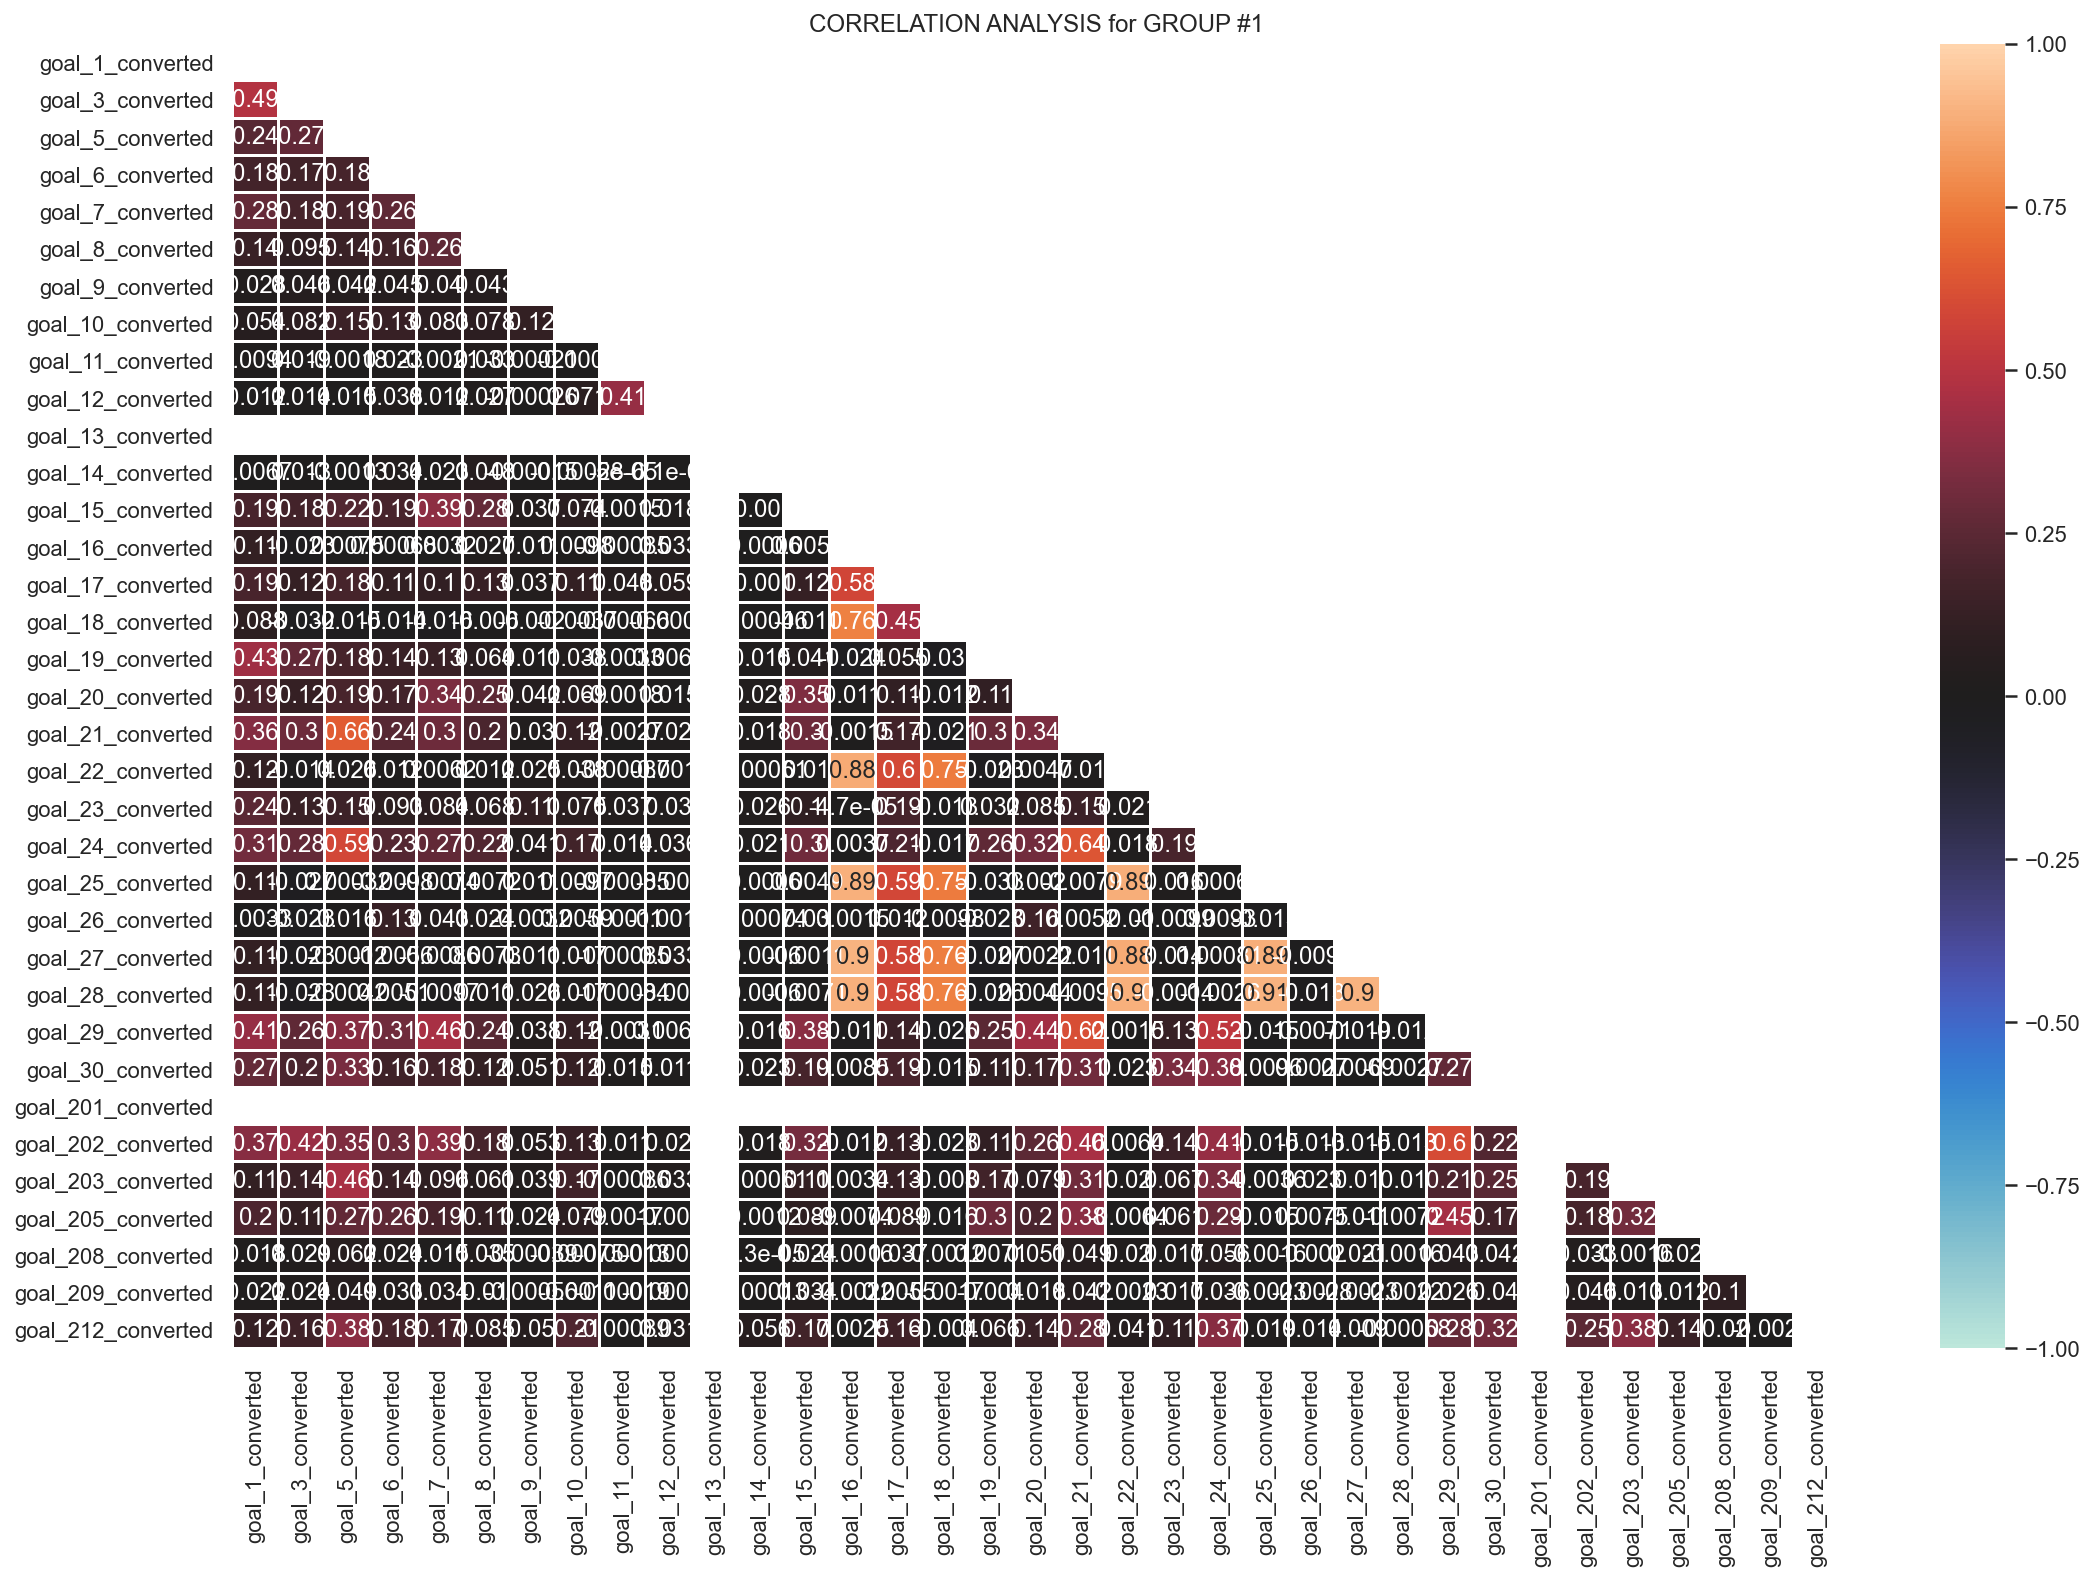

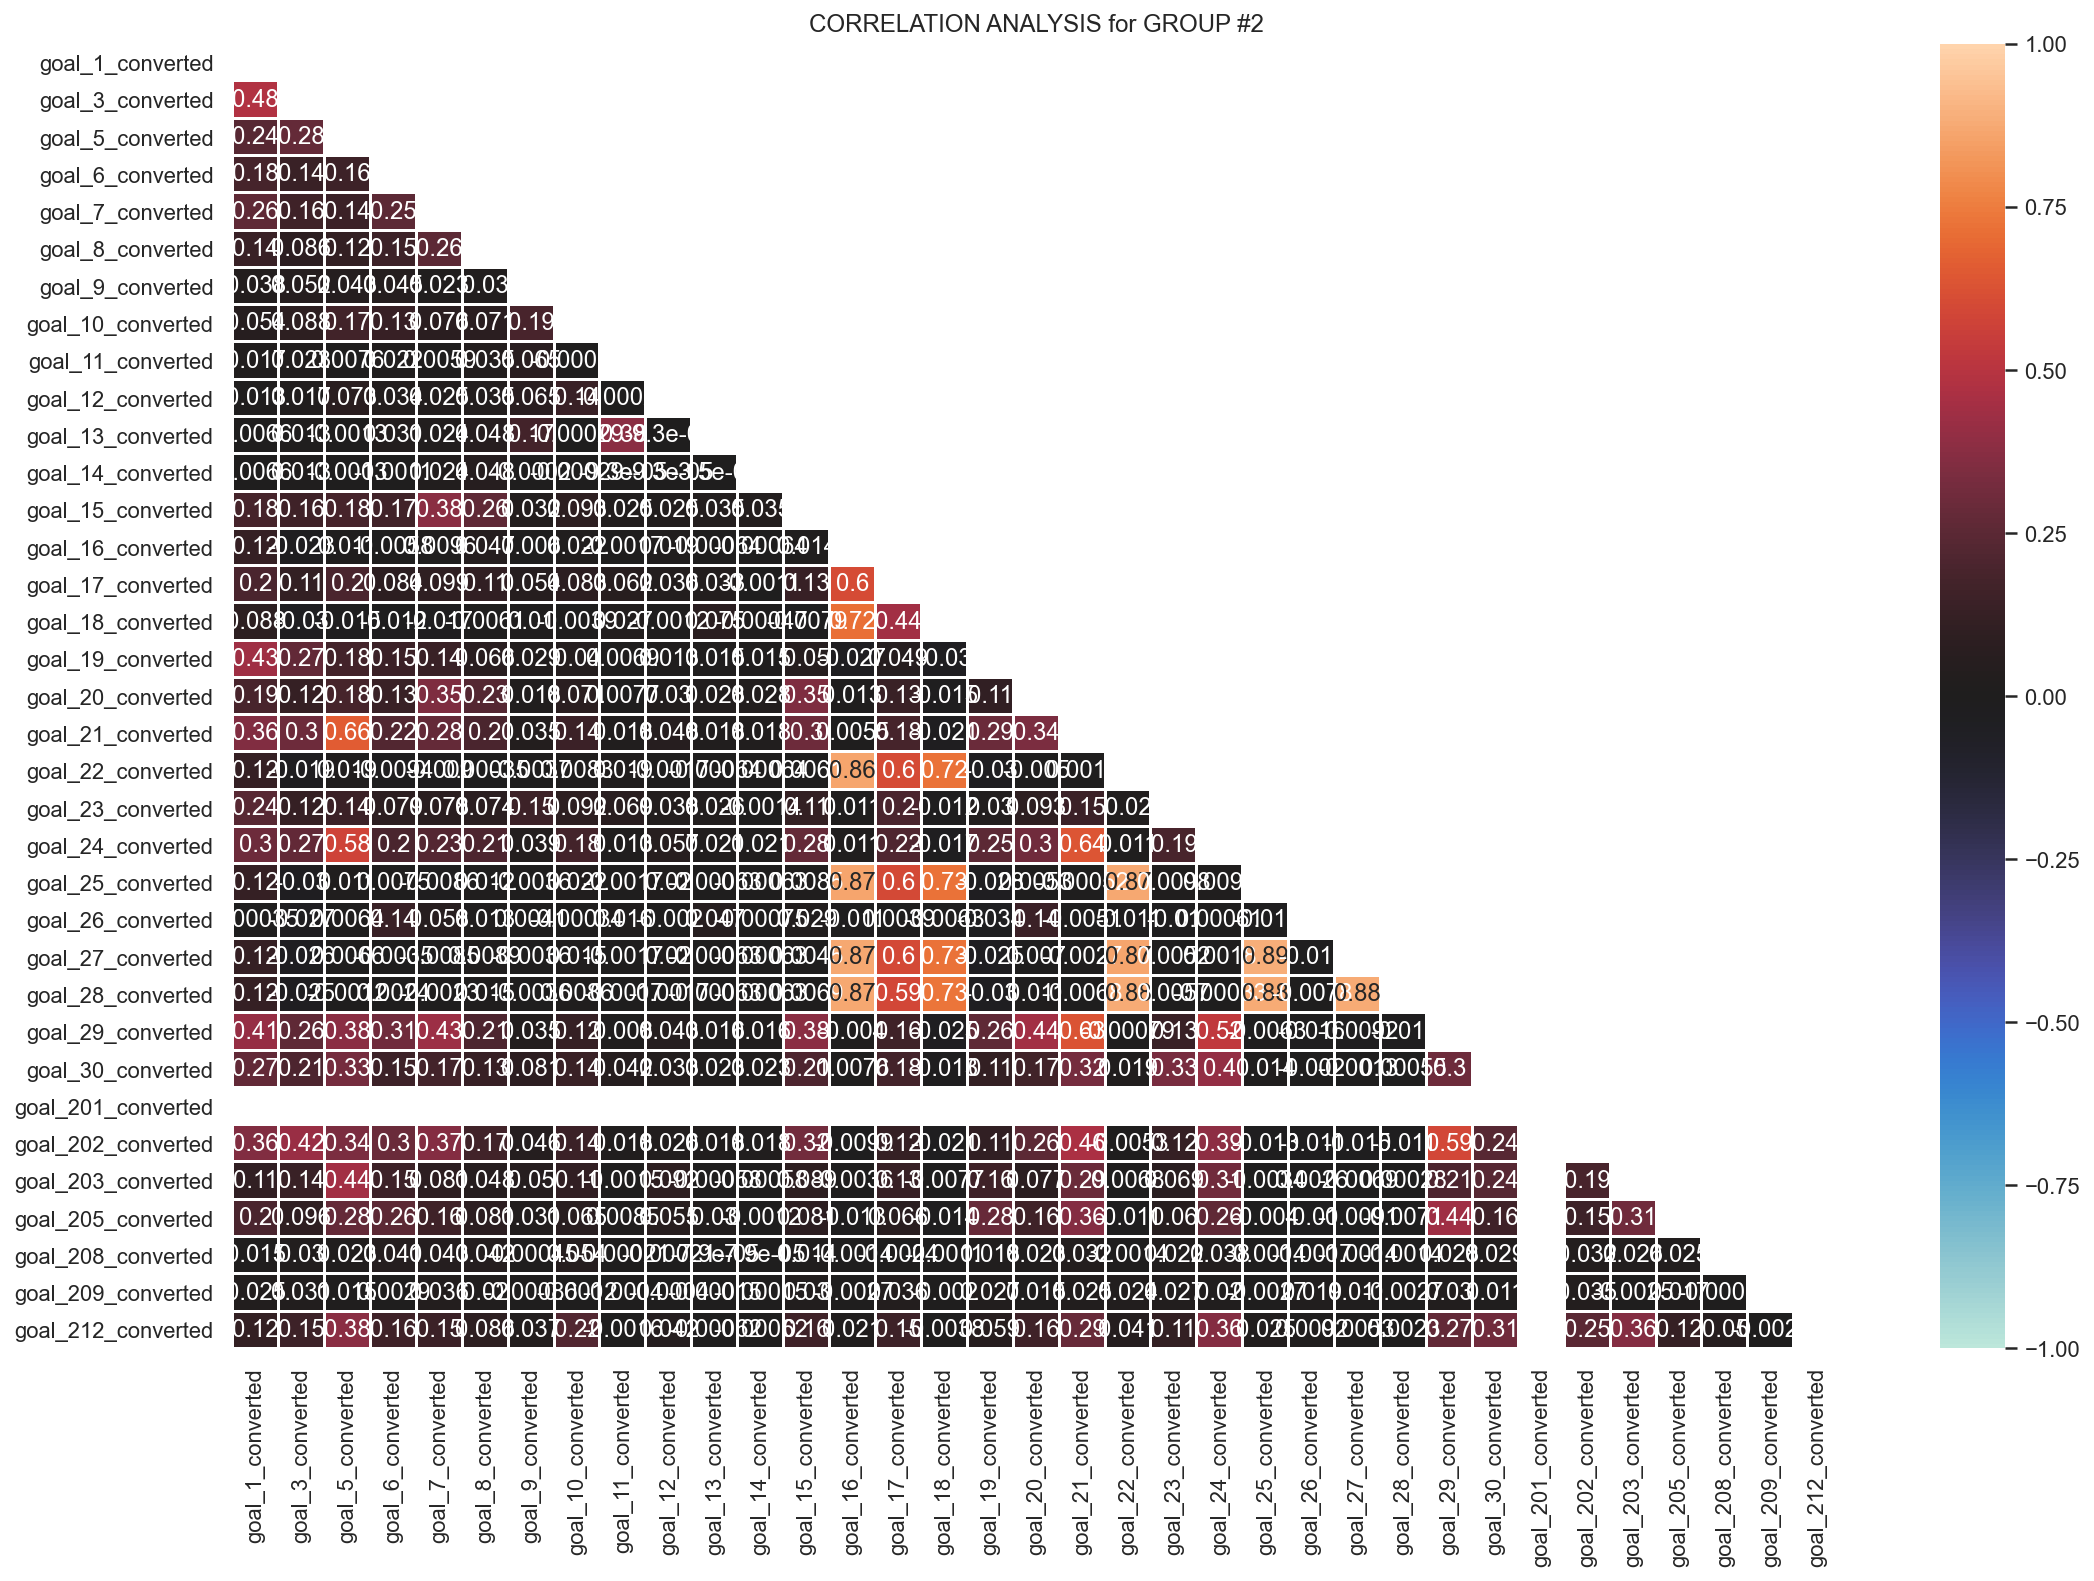

In [42]:
for x in range(1, df.combination_id.nunique()+1):
    corr_new = df[df['combination_id'] == x][converted].corr()
    mask = np.zeros_like(corr_new)
    mask[np.triu_indices_from(mask)] = True
    
    
    ax_nulls = plt.subplots(figsize=(18, 12))
    ax_nulls = sns.heatmap(corr_new,\
                          mask=mask,\
                          vmin=-1, vmax=1, annot=True, linewidths=1, center=0
                          )
    ax_nulls.set_title('CORRELATION ANALYSIS for GROUP #{}'.format(x))

In [32]:
df.groupby('combination_id').size()

combination_id
1    28470
2    28325
dtype: int64

In [33]:
df.shape

(56795, 144)

## p_values

In [34]:
meta.iloc[:, :-1]

category   id                         name               type  \
0          goal    1                   engagement         engagement   
1          goal    3                 ctr_on_login          clickLink   
2          goal    5   all_payment_systems_submit       clickElement   
3          goal    6          learn_more_link_ctr          visitPage   
4          goal    7       get_started_offers_ctr          visitPage   
5          goal    8                 tourneys_ctr          visitPage   
6          goal    9      mystery_museum_demo_ctr          visitPage   
7          goal   10      mystery_museum_play_ctr          visitPage   
8          goal   11           rock_roll_demo_ctr          visitPage   
9          goal   12           rock_roll_play_ctr          visitPage   
10         goal   13               aloha_demo_ctr          visitPage   
11         goal   14               aloha_play_ctr          visitPage   
12         goal   15            adventure_log_ctr          visitPage   
13         goal   16      playson_game_search_ctr          visitPage   
14         goal   17              game_search_ctr          visitPage   
15         goal   18     redtiger_game_search_ctr          visitPage   
16         goal   19                ctr_on_signup          visitPage   
17         goal   20            statusprogram_ctr          visitPage   
18         goal   21             cashier_open_ctr          visitPage   
19         goal   22      playngo_game_search_ctr          visitPage   
20         goal   23                    demo_game          visitPage   
21         goal   24                    play_game          visitPage   
22         goal   25    quickspin_game_search_ctr          visitPage   
23         goal   26        responsiblegaming_ctr          visitPage   
24         goal   27  microgaming_game_search_ctr          visitPage   
25         goal   28    yggdrasil_game_search_ctr          visitPage   
26         goal   29                cabinet/promo          visitPage   
27         goal   30                  games/slots          visitPage   
28         goal  201             signup_completed  custom-conversion   
29         goal  202              login_completed  custom-conversion   
30         goal  203                          ftd  custom-conversion   
31         goal  205              email_confirmed  custom-conversion   
32         goal  206              retention_day_1  custom-conversion   
33         goal  207              retention_day_3  custom-conversion   
34         goal  208              retention_day_5  custom-conversion   
35         goal  209              retention_day_7  custom-conversion   
36         goal  212             bonus_activation  custom-conversion   
37  combination    1                      Control                NaN   
38  combination    2                  Variation 1                NaN   
39     campaign  135                      Stories                NaN   

      created_timestamp  
0   2021-11-18 10:26:51  
1   2021-11-18 10:26:51  
2   2021-11-18 10:26:51  
3   2022-02-03 19:51:59  
4   2022-02-03 19:53:19  
5   2022-02-03 19:54:25  
6   2022-02-03 19:56:33  
7   2022-02-03 19:56:33  
8   2022-02-03 19:57:39  
9   2022-02-03 19:58:27  
10  2022-02-03 19:59:52  
11  2022-02-03 19:59:52  
12  2022-02-03 20:00:49  
13  2022-02-03 20:24:14  
14  2022-02-03 20:24:14  
15  2022-02-03 20:27:00  
16  2022-02-03 20:28:10  
17  2022-02-03 20:30:49  
18  2022-02-03 20:36:11  
19  2022-02-03 20:40:49  
20  2022-02-03 20:46:26  
21  2022-02-03 20:46:26  
22  2022-02-03 20:59:29  
23  2022-02-03 21:01:58  
24  2022-02-03 21:03:12  
25  2022-02-03 21:04:19  
26  2022-02-03 21:08:03  
27  2022-02-03 21:08:38  
28  2021-11-18 10:26:51  
29  2022-02-03 20:34:38  
30  2021-11-18 10:26:51  
31  2021-11-18 10:26:51  
32  2021-11-18 10:26:51  
33  2021-11-18 10:26:51  
34  2021-11-18 10:26:51  
35  2021-11-18 10:26:51  
36  2021-11-18 10:26:51  
37                  NaN  
38                  NaN  
39            

In [36]:
abt.p_factor('user_language', goal='goal_212_converted', df=df, min_visitors=0)

user_language  visitors_A  visitors_B  n_of_conversions_A  \
0         en_gb        1266        1261                  28   
1            ro        1592        1661                  29   
2         ro_ro        4369        4342                 155   

   n_of_conversions_B  cr_A  cr_B  relative_uplift  p_value  absolute_uplift  \
0                  30  2.21  2.38             7.57    0.389             0.17   
1                  31  1.82  1.87             2.46    0.462             0.04   
2                 148  3.55  3.41            -3.92    0.362            -0.14   

   srm-p_value  
0     0.920770  
1     0.226363  
2     0.772361

In [35]:
goal = 1
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p_value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p_value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY p_value RESULT
result[result['p_value']<=0.2].sort_values(by=['p_value'], ascending=True).style\
            .bar(subset=['p_value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category  id        name        type    created_timestamp  info
0          goal   1  engagement  engagement  2021-11-18 10:26:51   NaN
37  combination   1     Control         NaN                  NaN   NaN

In [ ]:
goal_number = 1
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


device_type  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0      mobile    12482    12575    6.0    7.0   13.0   13.0

FACTOR - RETURNING_VISITOR


returning_visitor  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0          new_user    10216    10343    6.0    7.0   13.0   13.0
1    returning_user     2276     2237    6.0    6.0   12.0   12.0

FACTOR - OS


os  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0  android    10217    10288    7.0    7.0   13.0   14.0
1      ios     2265     2287    4.0    4.0   11.0   11.0

FACTOR - BROWSER


browser  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0             chrome      366      389    8.5    8.0   16.0   15.0
1      chrome_mobile     8592     8620    7.0    7.0   13.0   13.0
2  chrome_mobile_ios      296      285    5.0    5.0   11.0   10.0
3           facebook      244      232    8.0    8.5   14.0   14.0
4             google       94      105    5.0    5.0   12.0   10.0
5        miuibrowser       99      111    9.0    9.0   14.0   18.0
6             safari     1793     1814    4.0    4.0   10.0   10.0
7   samsung_internet      850      870    8.0    9.0   16.0   16.0

FACTOR - COUNTRY


country  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0       bangladesh      214      223    8.0    9.0  15.75  16.00
1         bulgaria       87       79    4.0    4.0   7.50   7.00
2           canada      151      137   12.0   11.0  21.50  21.00
3          finland     2818     2958    5.0    6.0  11.00  11.00
4           france       67       63    7.0    8.0  15.50  17.00
5          georgia      242      203    7.0    8.0  14.00  14.00
6          germany       88       96    6.0    7.0  13.00  14.00
7            india     1119     1180    7.0    8.0  15.00  16.00
8        indonesia      122      122   12.0   11.0  21.00  18.75
9         malaysia      190      185   10.0   14.0  20.00  25.00
10     netherlands      311      310    5.0    4.0  11.00  12.00
11          poland       58       52    8.0    7.5  18.75  14.25
12         romania     5087     5085    6.0    6.0  12.00  12.00
13          sweden      341      309    5.0    4.0  11.00  10.00
14     switzerland       67       56    4.0    4.5   7.50  10.25
15        thailand      552      542    9.0    9.0  19.00  18.75
16  united_kingdom       83       79    6.0    5.0  12.00  11.50
17   united_states       73       81    8.0    8.0  20.00  16.00

FACTOR - USER_LANGUAGE


user_language  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0          bg_bg       77       87    5.0    5.0   8.00  13.00
1          en_ca      105       92   10.0   10.0  20.00  20.00
2          en_gb      935      915    6.0    7.0  13.00  14.00
3          en_in      278      291    7.0    8.0  14.00  16.00
4          en_us     3888     4062    6.0    6.0  12.00  12.00
5          fi_fi       68       55    3.0    3.0   5.25   6.00
6          id_id      121      109   12.0   13.0  21.00  21.00
7          ka_ge       78       67    7.5    8.0  13.75  16.00
8          ms_my       70       60   12.5   13.5  23.00  22.00
9          pl_pl       77       77    8.0    9.0  26.00  20.00
10         pt_pt       60       77    5.0    6.0  13.00  10.00
11            ro     1209     1260    7.0    7.0  12.00  13.00
12         ro_ro     3462     3418    6.0    6.0  13.00  13.00
13            ru      104       88    5.0    5.0   8.00  12.25
14         ru_ru      212      203    7.0    7.0  14.00  15.00
15         sv_se      274      251    5.0    4.0  11.00  10.00
16            th       64       58    8.0    8.0  13.00  12.00
17         th_th      474      466    9.0    9.0  19.00  20.00

FACTOR - LAND


land  count_A  count_B  50%_A  50%_B  75%_A  75%_B
0  False    12205    12302    6.0    6.0   13.0   13.0
1   True      287      278    8.0    9.0   19.5   18.0

In [ ]:
goal = 3
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p_value']<=0.2].sort_values(by=['p_value'], ascending=True).style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category  id         name       type    created_timestamp  info
2         goal   3    play_game  visitPage  2022-02-09 11:52:49   NaN
9  combination   3  Variation 2        NaN                  NaN   NaN

In [ ]:
goal = 3
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p_value']<=0.2].sort_values(by=['p_value'], ascending=True).style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category  id         name       type    created_timestamp  info
2         goal   3    play_game  visitPage  2022-02-09 11:52:49   NaN
9  combination   3  Variation 2        NaN                  NaN   NaN

In [ ]:
goal = 203
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p_value']<=0.2].sort_values(by=['p_value'], ascending=True).style\
            .bar(subset=['p_value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


category   id name               type    created_timestamp  info
5     goal  203  ftd  custom-conversion  2021-11-22 11:23:32   NaN

### TIMESTAMPS

In [ ]:
df.groupby('combination_id')['3_goal_secs'].describe()

count          mean            std  min   25%    50%     75%  \
combination_id                                                                  
1               3443.0  50274.914900  159349.543472 -3.0  96.0  202.0  775.00   
2               3345.0  48572.999701  162241.022113  0.0  97.0  201.0  803.00   
3               3366.0  45784.442662  155456.998672  0.0  95.0  202.0  720.75   

                      max  
combination_id             
1               1259376.0  
2               1250563.0  
3               1145337.0

In [ ]:
goal_number = 203
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


device_type  count_A  count_B  50%_A  50%_B    75%_A  75%_B
0     desktop       90       97  435.5  338.0  1012.25  661.0
1      mobile      318      291  374.0  352.0  1117.75  996.5

FACTOR - RETURNING_VISITOR


returning_visitor  count_A  count_B  50%_A  50%_B   75%_A   75%_B
0          new_user      355      328  375.0  344.5  1049.0   733.5
1    returning_user       55       62  492.0  390.5  8760.5  6446.5

FACTOR - OS


os  count_A  count_B  50%_A  50%_B    75%_A    75%_B
0  android      204      194  398.5  376.5  1704.50   946.25
1      ios      116       99  307.5  321.0   703.75  1093.50
2  windows       84       92  421.0  341.0   956.00   666.75

FACTOR - BROWSER


browser  count_A  count_B  50%_A  50%_B    75%_A   75%_B
0         chrome       87       93  413.0  323.0   962.00   735.0
1  chrome_mobile      161      161  395.0  353.0  1684.00   805.0
2         safari      102       91  303.0  314.0   628.75  1093.5

FACTOR - COUNTRY


country  count_A  count_B  50%_A  50%_B    75%_A   75%_B
0  romania      259      269  465.0  424.0  1568.50  1411.0
1   sweden      110       93  227.0  216.0   319.25   350.0

FACTOR - USER_LANGUAGE


user_language  count_A  count_B  50%_A  50%_B   75%_A   75%_B
0         ro_ro      158      155  476.5  459.0  1924.5  1735.5
1         sv_se       88       76  217.5  202.5   359.5   348.5

FACTOR - LAND


land  count_A  count_B  50%_A  50%_B   75%_A  75%_B
0  False      409      390  379.0  347.0  1119.0  829.5

In [ ]:
df.groupby('combination_id')['208_goal_secs'].describe()

count           mean            std       min       25%  \
combination_id                                                            
1                13.0  503938.538462   41265.542098  433003.0  464778.0   
2                14.0  620443.642857  239262.968641  439923.0  499729.0   

                     50%       75%        max  
combination_id                                 
1               511788.0  527786.0   562945.0  
2               526446.5  598768.5  1334071.0

In [ ]:
goal_number = 203
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


device_type  count_A  count_B  50%_A  50%_B    75%_A    75%_B
0     desktop       81      103  146.0  209.0   544.00    517.0
1      mobile      322      306  264.5  356.0  1266.75  23172.5

FACTOR - RETURNING_VISITOR


returning_visitor  count_A  count_B  50%_A  50%_B   75%_A     75%_B
0          new_user      335      328  245.0  246.5   872.5   1227.50
1    returning_user       71       82  291.0  921.0  4675.0  72721.75

FACTOR - OS


os  count_A  count_B  50%_A  50%_B    75%_A    75%_B
0  android      235      226  300.0  456.5  3578.50  72946.0
1      ios       90       81  186.0  246.0   424.25    574.0
2  windows       76       93  180.0  216.0   638.50    574.0

FACTOR - BROWSER


browser  count_A  count_B  50%_A  50%_B    75%_A    75%_B
0         chrome       76       95  192.0  207.0  1066.50    559.0
1  chrome_mobile      175      174  294.0  589.5  3578.50  77292.0
2         safari       80       71  172.0  240.0   400.75    523.5

FACTOR - COUNTRY


country  count_A  count_B  50%_A  50%_B    75%_A    75%_B
0  romania      328      331  237.0  298.0  1262.25  13514.0

FACTOR - USER_LANGUAGE


user_language  count_A  count_B  50%_A  50%_B    75%_A    75%_B
0         en_us       60       65  152.5  216.0   562.75    675.0
1            ro       57       65  732.0  606.0  9947.00  78457.0
2         ro_ro      194      188  255.5  327.0  1204.25  17412.5

FACTOR - LAND


land  count_A  count_B  50%_A  50%_B    75%_A   75%_B
0  False      406      410  249.0  291.0  1063.25  3930.0

## ARPU & ARPPU

In [ ]:
# FIND REVENUE GOALS
revenue = df.columns[df.columns.str.startswith('goal_') & df.columns.str.endswith('_revenue')]
revenue = revenue[0]
revenue

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
revenue_converted = revenue.split('revenue')[0] + 'converted'
revenue_converted

'goal_3_converted'

In [ ]:
df[revenue].mean()

35.2799267935579

In [ ]:
arppu = df.groupby(['combination_id'])[revenue].mean()
arppu

combination_id
1    38.046553
2    34.742490
3    32.764783
Name: goal_3_revenue, dtype: float64

In [ ]:
df.groupby(['combination_id'])[revenue].count()

combination_id
1    235
2    241
3    207
Name: goal_3_revenue, dtype: int64

In [ ]:
df.groupby(['combination_id'])[revenue_converted].sum()

combination_id
1    235
2    241
3    207
Name: goal_3_converted, dtype: int64

In [ ]:
df.groupby(['combination_id'])[revenue_converted].count()

combination_id
1    1366
2    1399
Name: goal_3_converted, dtype: int64

In [ ]:
df[[revenue, revenue_converted]]

goal_3_revenue  goal_3_converted
0              15.97                 1
1                NaN                 0
2              11.41                 1
3                NaN                 0
4                NaN                 0
...              ...               ...
4157             NaN                 0
4158             NaN                 0
4159             NaN                 0
4160             NaN                 0
4161             NaN                 0

[4144 rows x 2 columns]

In [ ]:
df.groupby('combination_id')[revenue].sum()

combination_id
1    8940.94
2    8372.94
3    6782.31
Name: goal_3_revenue, dtype: float64

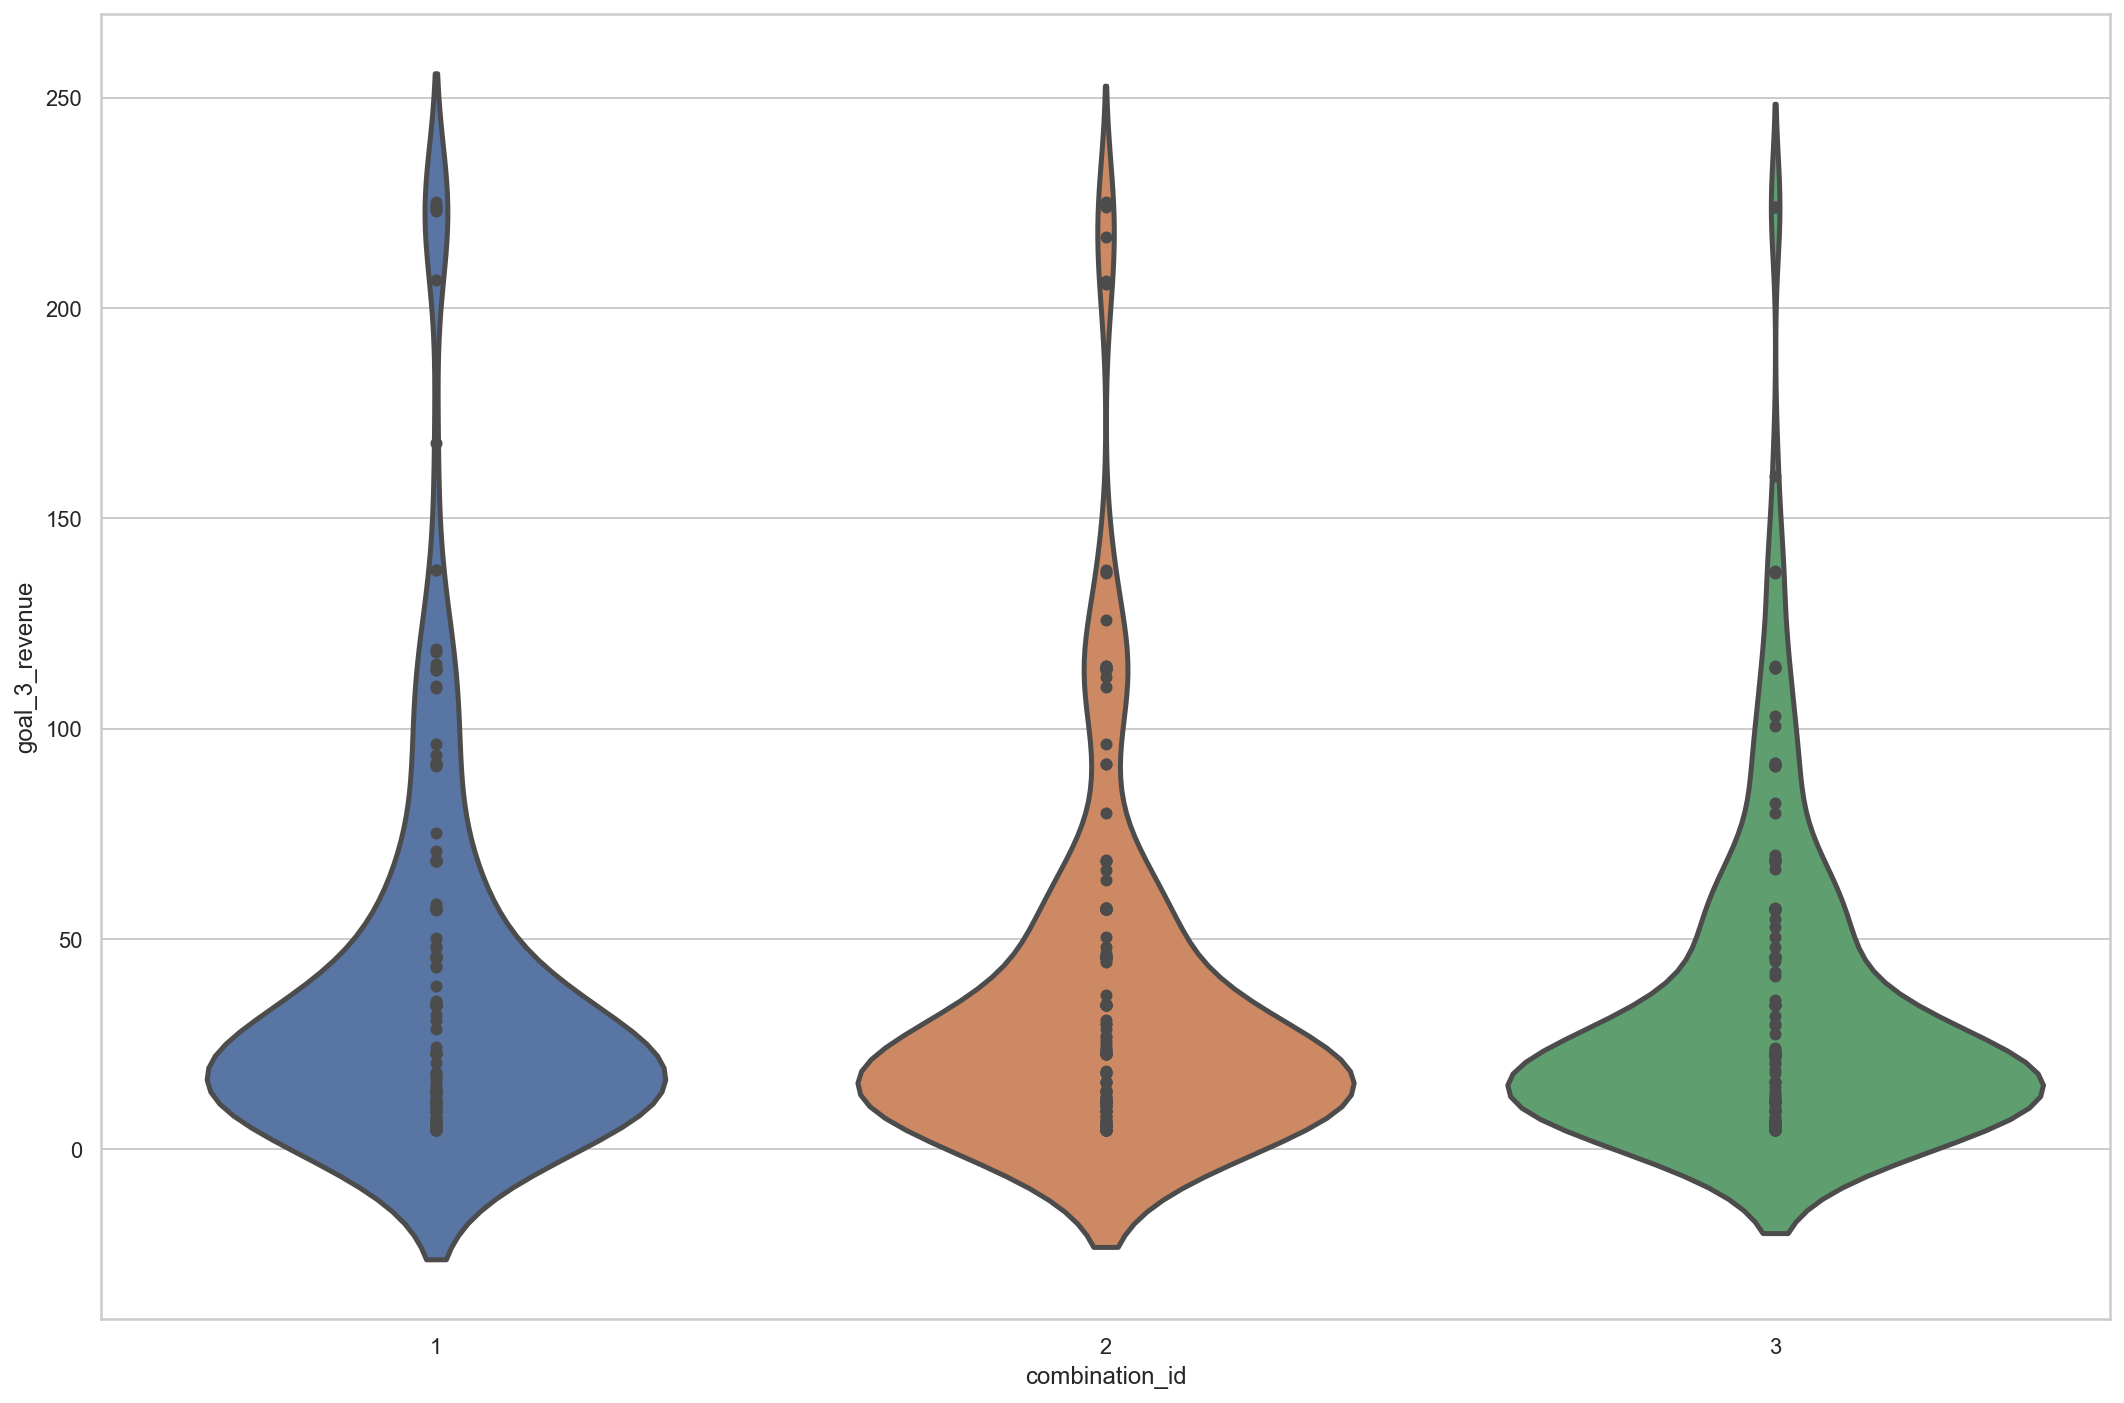

In [ ]:
ax_nulls = plt.subplots(figsize=(18, 12))
ax_nulls = sns.violinplot(x='combination_id',\
                       y=df[revenue],\
                       data=df,\
#                        hue='os',\
                       linewidth=2.5,\
                       inner='point',\
                      )
# plt.axis([-1, 2, -75, 200])

## RUNNING EXPERIMENTS

In [ ]:
import requests

url = "https://app.vwo.com/api/v2/accounts/{}/campaigns?status=RUNNING".format(FC)

headers = {
    "Accept": "application/json",
    "token": "90d8bd096a224e7f6b72a2000bab409d7a8063aba48d7a4424e9220de96483bd"
}

response = requests.request("GET", url, headers=headers)
json = response.json()

In [ ]:
import requests
for x in [539414, 527076, 539416, 539420, 529239]:
    url = "https://app.vwo.com/api/v2/accounts/{}/campaigns?status=RUNNING".format(x)

    headers = {
        "Accept": "application/json",
            "token": "90d8bd096a224e7f6b72a2000bab409d7a8063aba48d7a4424e9220de96483bd"
}
    response = requests.request("GET", url, headers=headers)
    json = response.json()

In [ ]:
exps = pd.json_normalize(json['_data'])

In [ ]:
exps.query('status=="RUNNING" & type=="ab"').iloc[:, :10]

id                                                  name type platform  \
0  146  [PRT-360][Prod] Slotv рекомендательная система "ALS"   ab  website   
1  140            [SC-6665][ABT-58] Redesign of User Profile   ab  website   

    status   createdOn  isDeleted labels                        primaryUrl  \
0  RUNNING  1640007829      False     []  https://slotv.com/ru/games/slots   
1  RUNNING  1638533597      False     []              https://slotv.com/en   

                                                                                                  urls  
0  [{'type': 'pattern', 'value': 'https://slotv.com/*/games/slots'}, {'type': 'endsWith', 'value': ...  
1  [{'type': 'pattern', 'value': 'https://slotv.ro/*'}, {'type': 'pattern', 'value': 'https://slotv...

## CONNECT HEAPPO

In [ ]:
import psycopg2
connect = psycopg2.connect(host="10.208.72.65", port = 6432, database="heappo", user="rodion_ter_ro_user", password="dv33msfu84ndjsh3bz7")
cur = connect.cursor()

In [ ]:
cur.execute("""
SELECT * FROM gambling.vwo_experiments WHERE (campaign_id = 123)""")

In [ ]:
colnames = [desc[0] for desc in cur.description]

In [ ]:
query_results = cur.fetchall()
sql_stage = pd.DataFrame(query_results, columns=colnames)

In [ ]:
sql_stage

vwo_uuid  user_id  campaign_id  \
0   D0BECCC30FA802E026FDCED4EDF509153        0          123   
1   D0BECCC30FA802E026FDCED4EDF509153    14420          123   
2   D0BECCC30FA802E026FDCED4EDF509153    14472          123   
3   D19C7825402079C8D905421DF425F740B        0          123   
4   D5C4D85FF9A896A88F503C56C36E9B228        0          123   
5   D79FDD104A6C9C32C4E3AEDEBE9ADBDF3        0          123   
6   D954E5D9AFCEE919FAFC96B55A897161C        0          123   
7   DBA8B9B13C28EC935B000A82D8DAC0CE3        0          123   
8   DED2F795D5F370974113EE2B2086AA6EF        0          123   
9   DED2F795D5F370974113EE2B2086AA6EF        0          123   
10  DED2F795D5F370974113EE2B2086AA6EF    12896          123   
11  DED2F795D5F370974113EE2B2086AA6EF    14275          123   
12  DED2F795D5F370974113EE2B2086AA6EF    15841          123   
13  DED2F795D5F370974113EE2B2086AA6EF    16034          123   
14  DED2F795D5F370974113EE2B2086AA6EF    16037          123   
15  DFBAD4C8B78B4F49EDA3E03A3BCE42A59        0          123   
16  DFBAD4C8B78B4F49EDA3E03A3BCE42A59        0          123   

              campaign_name campaign_type             variations  \
0   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
1   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
2   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
3   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
4   [SC] ABT-34 New Cashier            ab                     []   
5   [SC] ABT-34 New Cashier            ab     [{'1': 'Control'}]   
6   [SC] ABT-34 New Cashier            ab     [{'1': 'Control'}]   
7   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
8   [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
9   [SC] ABT-34 New Cashier            ab                     []   
10  [SC] ABT-34 New Cashier            ab                     []   
11  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
12  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
13  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
14  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
15  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   
16  [SC] ABT-34 New Cashier            ab  [{'2': 'New Widget'}]   

                                                     goals            version  \
0                                                       {}  1636444015.934939   
1                                                       {}  1636018473.052552   
2                                                       {}  1635949337.783359   
3                                                       {}  1636130208.277771   
4                                                       {}  1635932675.318724   
5                                      {'2': 'engagement'}  1636369223.364676   
6                                      {'2': 'engagement'}  1636036804.228605   
7                                                       {}   1636124360.25595   
8                                      {'2': 'engagement'}    1636452362.4681   
9                                                       {}  1636460466.972378   
10                                                      {}  1636460452.467214   
11                                     {'2': 'engagement'}  1636369492.230248   
12                                     {'2': 'engagement'}  1636104503.089337   
13                                     {'2': 'engagement'}  1636106874.558825   
14                                     {'2': 'engagement'}  1636105384.755438   
15  {'2': 'engagement', '9': 'all_payment_systems_change'}  1635949038.228406   
16  {'2': 'engagement', '9': 'all_payment_systems_change'}  1635867119.473796   

            rest project_id              created_at              updated_at  
0   {'id': 1950}        sc1 2021-11-03 08:41:37.467 2021-11-03 14:21:05.664  
1   {'id': 1964}        sc1 2021-11-04 09:33:31.449 20

In [ ]:
cur.close()
connect.close()

## DRAFT